In [1]:
# 0. 환경 설정 및 라이브러리 임포트 (이전과 동일)
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.ndimage import median_filter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier # RFE estimator로 사용 (빠름)
import glob
from PIL import Image
import seaborn as sns

# 딥러닝 관련 라이브러리
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 불균형 처리 라이브러리
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# 음성 증강 라이브러리
!pip install audiomentations
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch

# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

# === 전역 설정 (PDF와 동일) ===
CLIP_DURATION = 3 # 이 프로젝트에서는 가변 길이 세그먼트 추출 후 특징 집계이므로 직접적인 클립 자르기에는 사용하지 않음
SR = 22050 # Sampling Rate
N_MFCC = 13 # MFCC 계수 수

# === 경로 설정 (PDF와 동일) ===
ANNOTATION_FILE = '/content/drive/MyDrive/Colab Notebooks/Tasmanian Birdsong/annotations.csv'
WAV_DIR = '/content/drive/MyDrive/Colab Notebooks/Tasmanian Birdsong'
FEATURES_DIR = '/content/drive/MyDrive/Colab Notebooks/Tasmanian Birdsong/features'
IMAGE_DIR = os.path.join(FEATURES_DIR, "image") # Traditional ML 모델용 이미지 (평탄화 예정)
NUMERIC_DIR = os.path.join(FEATURES_DIR, "numerical")
DL_IMAGE_DIR = os.path.join(FEATURES_DIR, "dl_images") # 딥러닝 모델용 멜-스펙트로그램 이미지

# 필요한 디렉토리 생성
os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(NUMERIC_DIR, exist_ok=True)
os.makedirs(DL_IMAGE_DIR, exist_ok=True)

print("환경 설정 및 라이브러리 임포트 완료.")


# --- (이전과 동일한) 특징 추출 및 이미지 저장 헬퍼 함수들 ---
def extract_numerical_features(y, sr, n_mfcc=N_MFCC):
    feature_dict = {}
    y = median_filter(y, size=3) # 노이즈 감소

    # MFCC (mean, std)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    for i in range(n_mfcc):
        feature_dict[f'mfcc{i+1}_mean'] = np.mean(mfcc[i])
        feature_dict[f'mfcc{i+1}_std'] = np.std(mfcc[i])

    # ZCR (mean, std)
    zcr = librosa.feature.zero_crossing_rate(y)
    feature_dict['zcr_mean'] = np.mean(zcr)
    feature_dict['zcr_std'] = np.std(zcr)

    # RMS (mean, std)
    rms = librosa.feature.rms(y=y)
    feature_dict['rms_mean'] = np.mean(rms)
    feature_dict['rms_std'] = np.std(rms)

    # Spectral Centroid (mean, std)
    sc = librosa.feature.spectral_centroid(y=y, sr=sr)
    feature_dict['centroid_mean'] = np.mean(sc)
    feature_dict['centroid_std'] = np.std(sc)

    # Bandwidth (mean, std)
    bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    feature_dict['bandwidth_mean'] = np.mean(bw)
    feature_dict['bandwidth_std'] = np.std(bw)

    # Chroma features (mean, std)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    feature_dict['chroma_mean'] = np.mean(chroma)
    feature_dict['chroma_std'] = np.std(chroma)

    return feature_dict

def save_mfcc_spectrogram_image_for_ml(y, sr, save_path, target_size=(128, 128)):
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    plt.figure(figsize=(4, 3))
    librosa.display.specshow(mfcc, sr=sr, x_axis='time')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    img = Image.open(save_path).convert('L')
    img = img.resize(target_size)
    img.save(save_path)

def save_mel_spectrogram_for_dl(y, sr, save_path, target_size=(128, 128)):
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.figure(figsize=(target_size[0]/100, target_size[1]/100), dpi=100)
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()
    img = Image.open(save_path).convert('L')
    img = img.resize(target_size)
    img.save(save_path)


# === 1. Audio Preprocessing 메인 함수 (업데이트된 로직 포함) ===
def preprocess_audio_segments(annotation_df, wav_dir, sr=SR):
    all_data = []
    processed_files_cache = {} # WAV 파일을 한 번만 로드하기 위한 캐시

    print("=== Audio Preprocessing 시작: 가변 길이 세그먼트 추출 및 특징 준비 ===")

    for idx, row in annotation_df.iterrows():
        fname = row['sample']
        start = row['start']
        end = row['end']
        label = row['call_type']
        path = os.path.join(wav_dir, fname)

        # 1. CSV에만 존재하고 실제 파일이 없는 경우 건너뛰기
        if not os.path.exists(path):
            print(f"⚠️ 경고: 파일 없음 {path}. 건너뜁니다.")
            continue

        try:
            # 2. 오디오 로드 및 모노 변환 (캐싱 활용)
            if fname not in processed_files_cache:
                y_full, sr_native = librosa.load(path, sr=None, mono=True) # mono=True로 모노 변환
                y_resampled = librosa.resample(y_full, orig_sr=sr_native, target_sr=sr)
                processed_files_cache[fname] = y_resampled
            else:
                y_resampled = processed_files_cache[fname]

            duration_full_sec = len(y_resampled) / sr # 오디오 파일의 실제 총 길이 (초)

            # 3. end 시간 처리 (30초 초과 시 수정, 실제 길이 초과 시 수정)
            # end_time은 csv에서 가져온 값
            # segment_end_limit은 실제 오디오 파일 길이와 30초 중 더 작은 값
            segment_end_limit = min(duration_full_sec, 30.0) # 30초 또는 실제 오디오 길이 중 작은 값

            # 어노테이션된 end 시간이 segment_end_limit을 초과하면 수정
            adjusted_end = min(end, segment_end_limit)
            adjusted_start = start # start 시간은 그대로 사용

            # start 시간이 end 시간보다 크거나, 수정된 end 시간이 start 시간보다 작으면 건너뛰기
            if adjusted_start >= adjusted_end:
                 print(f"⚠️ 경고: {fname}의 세그먼트 시간 조정 후 start({adjusted_start:.2f}) >= end({adjusted_end:.2f}). 건너뜁니다.")
                 continue

            # 4. 가변 길이 세그먼트 추출
            segment = y_resampled[int(adjusted_start*sr):int(adjusted_end*sr)]
            segment_duration = len(segment) / sr

            if segment_duration <= 0: # 길이가 0이거나 음수인 세그먼트 방지
                print(f"⚠️ 경고: {fname}의 세그먼트({adjusted_start:.2f}-{adjusted_end:.2f}s) 길이가 0입니다. 건너뜁니다.")
                continue

            # 5. 고유한 클립 ID 생성 (원본 파일명, 조정된 start/end 시간, 고유 인덱스 활용)
            # 팀원이 제안한 (1), (2) 대신, 실제 세그먼트를 기반으로 고유 ID 생성
            # filename_start.end_label 형태로 생성하여 어노테이션 정보 반영
            clip_id = f"{fname.replace('.wav', '')}_{adjusted_start:.2f}_{adjusted_end:.2f}_{label}"

            # 6. Numerical Feature 추출 및 저장 (가변 길이 세그먼트에서 집계)
            numerical_features = extract_numerical_features(segment, sr)
            numerical_features['clip_id'] = clip_id
            numerical_features['label'] = label
            all_data.append(numerical_features)

            # 7. Image Feature 저장 (Traditional ML용 MFCC 스펙트로그램, DL용 멜-스펙트로그램)
            image_path_ml = os.path.join(IMAGE_DIR, f"{clip_id}.png")
            save_mfcc_spectrogram_image_for_ml(segment, sr, image_path_ml, target_size=(128, 128))

            image_path_dl = os.path.join(DL_IMAGE_DIR, f"{clip_id}.png")
            save_mel_spectrogram_for_dl(segment, sr, image_path_dl, target_size=(128, 128))

        except Exception as e:
            print(f"❌ 오류 발생: {fname}의 세그먼트 {start:.2f}-{end:.2f} 처리 중: {e}")

    # 모든 특징 데이터프레임으로 변환
    features_df = pd.DataFrame(all_data)
    numeric_features_path = os.path.join(NUMERIC_DIR, "features_all.csv")
    features_df.to_csv(numeric_features_path, index=False)

    print(f"✓ 수치적 특징이 '{numeric_features_path}'에 저장되었습니다.")
    print(f"✓ Traditional ML용 이미지 특징이 '{IMAGE_DIR}'에 저장되었습니다.")
    print(f"✓ Deep Learning용 이미지 특징이 '{DL_IMAGE_DIR}'에 저장되었습니다.")
    print(f"✓ 전처리된 총 클립 수: {len(features_df)}개")

    print("\n--- 전처리된 수치적 특징 미리보기 ---")
    display(features_df.head())
    print("\n--- 레이블 분포 ---")
    display(features_df['label'].value_counts())

    return features_df

# annotations.csv 로드 (PDF에서 사용된 경로)
annotation_df = pd.read_csv(ANNOTATION_FILE)
print(f"'{ANNOTATION_FILE}' 로드 완료. 총 어노테이션: {len(annotation_df)}개")

# 데이터 중복 확인 (PDF에 명시된 내용) - 이 부분은 이제 전처리 로직이 처리하므로 참고용
print("\n--- 원본 데이터의 중복 확인 (sample 기준) ---")
duplicated_samples = annotation_df[annotation_df.duplicated(subset=['sample'], keep=False)]
display(duplicated_samples.sort_values(by='sample'))

print("\n--- 원본 데이터의 중복 확인 (sample, start, end 기준) ---")
duplicate_check_subset = annotation_df.duplicated(subset=['sample', 'start', 'end'], keep=False)
duplicated_segments = annotation_df[duplicate_check_subset].sort_values(by='sample')
display(duplicated_segments)

# 전처리 함수 실행
features_df_processed = preprocess_audio_segments(annotation_df, WAV_DIR, sr=SR)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 10.4 MB/s eta 0:00:00
Mounted at /content/drive
환경 설정 및 라이브러리 임포트 완료.
'/content/drive/MyDrive/Colab Notebooks/Tasmanian Birdsong/annotations.csv' 로드 완료. 총 어노테이션: 699개

--- 원본 데이터의 중복 확인 (sample 기준) ---


,sample,species,call_type,start,end
9,FO020B_20240619_030000_16kHz_330_360.wav,Masked Owl,screech,5.70,8.04
10,FO020B_20240619_030000_16kHz_330_360.wav,Masked Owl,screech,16.98,19.98
20,FO020B_20240706_200000_16kHz_1320_1350.wav,Masked Owl,screech,12.16,16.24
21,FO020B_20240706_200000_16kHz_1320_1350.wav,Masked Owl,screech,22.12,25.93
46,FO025D_20240626_030000_16kHz_90_120.wav,Masked Owl,screech,0.62,4.01
...,...,...,...,...,...
621,TN039B_00045809_20241205T213900_16kHz_2610_264...,Masked Owl,screech,26.70,29.79
620,TN039B_00045809_20241205T213900_16kHz_2610_264...,Masked Owl,screech,5.24,7.87
696,TN039B_00045809_20241205T223900_16kHz_570_600.wav,Masked Owl,chattering,8.28,9.47
695,TN039B_00045809_20241205T223900_16kHz_570_600.wav,Masked Owl,chattering,6.48,8.04



--- 원본 데이터의 중복 확인 (sample, start, end 기준) ---


,sample,species,call_type,start,end


=== Audio Preprocessing 시작: 가변 길이 세그먼트 추출 및 특징 준비 ===


/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


✓ 수치적 특징이 '/content/drive/MyDrive/Colab Notebooks/Tasmanian Birdsong/features/numerical/features_all.csv'에 저장되었습니다.
✓ Traditional ML용 이미지 특징이 '/content/drive/MyDrive/Colab Notebooks/Tasmanian Birdsong/features/image'에 저장되었습니다.
✓ Deep Learning용 이미지 특징이 '/content/drive/MyDrive/Colab Notebooks/Tasmanian Birdsong/features/dl_images'에 저장되었습니다.
✓ 전처리된 총 클립 수: 699개

--- 전처리된 수치적 특징 미리보기 ---


,mfcc1_mean,mfcc1_std,mfcc2_mean,mfcc2_std,mfcc3_mean,mfcc3_std,mfcc4_mean,mfcc4_std,mfcc5_mean,mfcc5_std,...,rms_mean,rms_std,centroid_mean,centroid_std,bandwidth_mean,bandwidth_std,chroma_mean,chroma_std,clip_id,label
0,-486.297668,63.329796,50.275223,21.089073,-47.818485,29.917179,26.095371,5.300191,19.635693,17.885059,...,0.002140,0.001792,2960.441618,105.206769,2367.440028,261.375547,0.525828,0.262038,BD060A_CH01_20240328_220014_16kHz_290_320_9.00...,screech
1,-485.165375,100.177963,1.018407,39.597073,-40.889961,16.941183,33.135509,13.841019,-4.350334,9.015610,...,0.003462,0.003769,3942.768497,402.403465,2527.328672,143.807191,0.594507,0.251233,BD060A_CH01_20240331_210000_16kHz_660_690_19.9...,screech
2,-585.423279,9.097853,50.141830,4.416943,-27.814272,5.354625,16.326607,3.427655,-3.111303,5.536214,...,0.000316,0.000047,3395.396337,81.218401,2673.284087,31.605177,0.596817,0.251942,BD060A_CH01_20240331_210000_16kHz_1020_1050_16...,screech
3,-525.737427,11.490559,94.800583,3.222813,-4.643479,9.336382,27.626009,4.343479,8.960760,8.115784,...,0.001094,0.000126,2244.014676,93.769529,2554.399567,64.187180,0.624882,0.204718,CH07_20240703_180000_16kHz_1380_1410_23.12_25....,screech
4,-517.423584,15.813862,102.623230,4.437439,1.551965,12.621101,28.466991,4.341529,3.379509,11.194562,...,0.001201,0.000175,2109.671333,106.733547,2500.421218,90.618832,0.610699,0.226671,CH07_20240703_180000_16kHz_1810_1840_18.65_20....,screech



--- 레이블 분포 ---


,count
label,
screech,528
chattering,171



=== 특징 추출 및 시각화 ===


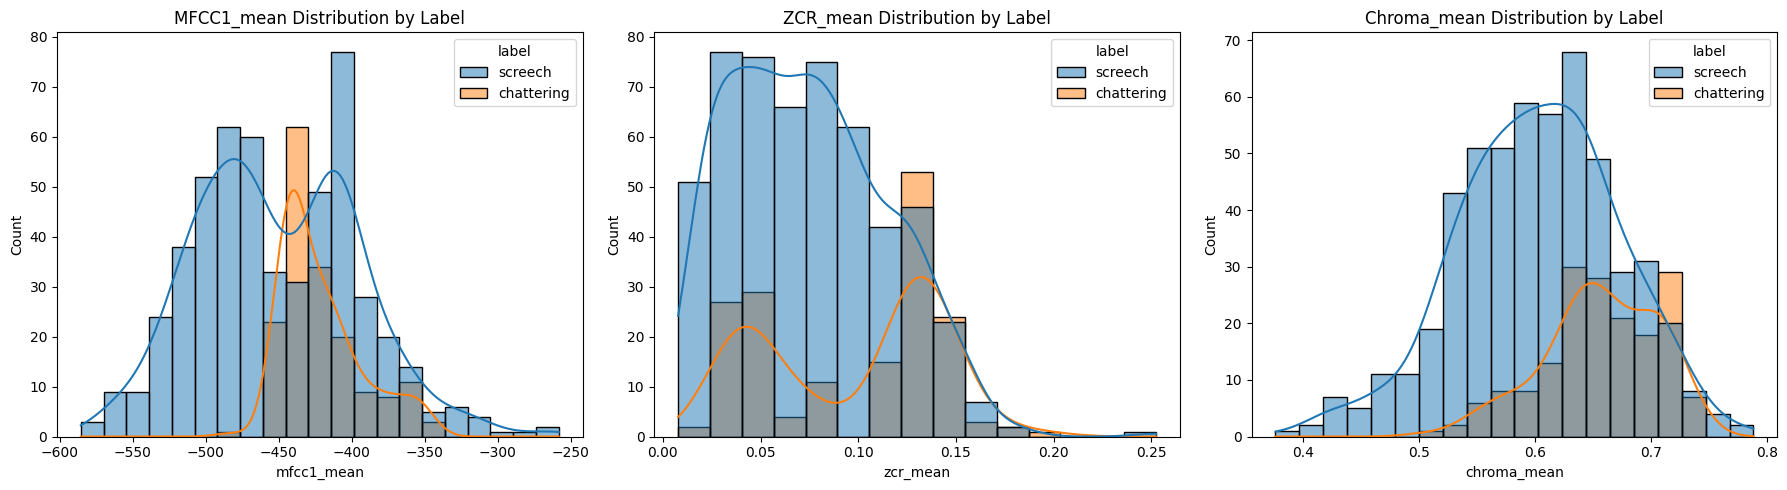


--- MFCC 스펙트로그램 이미지 샘플 (Traditional ML용) ---


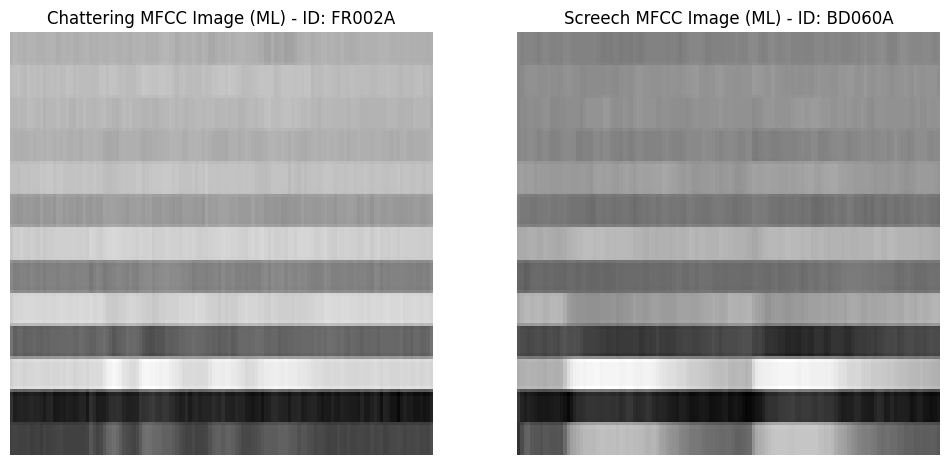


--- 멜-스펙트로그램 이미지 샘플 (Deep Learning용) ---


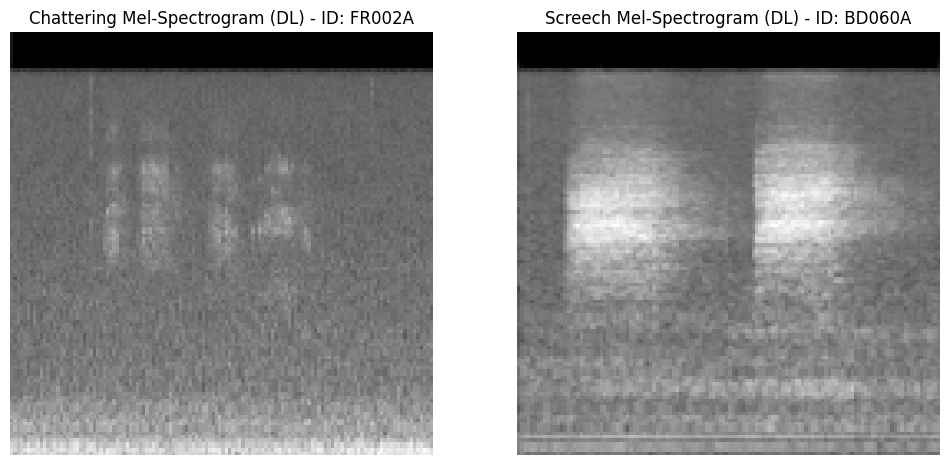

In [2]:
print("\n=== 특징 추출 및 시각화 ===")

# (참고: 특징 추출은 '1. Audio Preprocessing' 단계에서 이미 수행되었습니다.)

# 수치적 특징 데이터프레임 로드 (만약 Colab 세션이 끊어졌다면)
# features_df_processed = pd.read_csv(os.path.join(NUMERIC_DIR, "features_all.csv"))

# 수치적 특징의 분포 시각화 (예: MFCC1_mean, ZCR_mean, Chroma_mean)
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.histplot(data=features_df_processed, x='mfcc1_mean', hue='label', kde=True)
plt.title('MFCC1_mean Distribution by Label')

plt.subplot(1, 3, 2)
sns.histplot(data=features_df_processed, x='zcr_mean', hue='label', kde=True)
plt.title('ZCR_mean Distribution by Label')

plt.subplot(1, 3, 3)
sns.histplot(data=features_df_processed, x='chroma_mean', hue='label', kde=True)
plt.title('Chroma_mean Distribution by Label')
plt.tight_layout()
plt.show()

# 이미지 특징 시각화 (각 클래스별 샘플)
print("\n--- MFCC 스펙트로그램 이미지 샘플 (Traditional ML용) ---")
# 이미지 파일 경로 가져오기
sample_image_paths_ml = glob.glob(os.path.join(IMAGE_DIR, "*.png"))
chattering_img_path_ml = None
screech_img_path_ml = None

# features_df_processed와 이미지 경로를 매핑
image_ml_df = pd.DataFrame({
    'clip_id': features_df_processed['clip_id'],
    'label': features_df_processed['label'],
    'path': features_df_processed['clip_id'].apply(lambda x: os.path.join(IMAGE_DIR, f"{x}.png"))
})

for idx, row in image_ml_df.iterrows():
    if os.path.exists(row['path']):
        if row['label'] == 'chattering' and chattering_img_path_ml is None:
            chattering_img_path_ml = row['path']
        elif row['label'] == 'screech' and screech_img_path_ml is None:
            screech_img_path_ml = row['path']
    if chattering_img_path_ml and screech_img_path_ml:
        break

plt.figure(figsize=(12, 6))
if chattering_img_path_ml:
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(chattering_img_path_ml).convert('L'), cmap='gray')
    plt.title(f"Chattering MFCC Image (ML) - ID: {os.path.basename(chattering_img_path_ml).split('_')[0]}")
    plt.axis('off')
else:
    print("Chattering ML 샘플 이미지를 찾을 수 없습니다.")

if screech_img_path_ml:
    plt.subplot(1, 2, 2)
    plt.imshow(Image.open(screech_img_path_ml).convert('L'), cmap='gray')
    plt.title(f"Screech MFCC Image (ML) - ID: {os.path.basename(screech_img_path_ml).split('_')[0]}")
    plt.axis('off')
else:
    print("Screech ML 샘플 이미지를 찾을 수 없습니다.")
plt.show()

print("\n--- 멜-스펙트로그램 이미지 샘플 (Deep Learning용) ---")
# DL 이미지 파일 경로 가져오기
sample_dl_image_paths = glob.glob(os.path.join(DL_IMAGE_DIR, "*.png"))
chattering_dl_img_path = None
screech_dl_img_path = None

dl_image_df = pd.DataFrame({
    'clip_id': features_df_processed['clip_id'],
    'label': features_df_processed['label'],
    'path': features_df_processed['clip_id'].apply(lambda x: os.path.join(DL_IMAGE_DIR, f"{x}.png"))
})

for idx, row in dl_image_df.iterrows():
    if os.path.exists(row['path']):
        if row['label'] == 'chattering' and chattering_dl_img_path is None:
            chattering_dl_img_path = row['path']
        elif row['label'] == 'screech' and screech_dl_img_path is None:
            screech_dl_img_path = row['path']
    if chattering_dl_img_path and screech_dl_img_path:
        break

plt.figure(figsize=(12, 6))
if chattering_dl_img_path:
    plt.subplot(1, 2, 1)
    plt.imshow(Image.open(chattering_dl_img_path).convert('L'), cmap='gray')
    plt.title(f"Chattering Mel-Spectrogram (DL) - ID: {os.path.basename(chattering_dl_img_path).split('_')[0]}")
    plt.axis('off')
else:
    print("Chattering DL 샘플 이미지를 찾을 수 없습니다.")

if screech_dl_img_path:
    plt.subplot(1, 2, 2)
    plt.imshow(Image.open(screech_dl_img_path).convert('L'), cmap='gray')
    plt.title(f"Screech Mel-Spectrogram (DL) - ID: {os.path.basename(screech_dl_img_path).split('_')[0]}")
    plt.axis('off')
else:
    print("Screech DL 샘플 이미지를 찾을 수 없습니다.")
plt.show()

In [3]:
from sklearn.preprocessing import LabelEncoder

print("\n=== 모델 훈련 시작 ===")

# 데이터 분리 (Numerical Features)
X_num = features_df_processed.drop(['clip_id', 'label'], axis=1) #
y_num = features_df_processed['label'] #

# 레이블을 숫자로 인코딩 (모델 학습용)
le = LabelEncoder()
y_num_encoded = le.fit_transform(y_num)
print(f"레이블 인코딩: {list(le.classes_)} -> {list(range(len(le.classes_)))}")


# 훈련/테스트 세트 분리 (전통적 ML 및 DL 공통 인덱스 사용)
# stratify=y_num_encoded는 불균형한 레이블 분포를 훈련/테스트 세트에 동일하게 유지
X_train_num, X_test_num, y_train_num, y_test_num = train_test_split(
    X_num, y_num_encoded, test_size=0.2, random_state=42, stratify=y_num_encoded
)

# 수치적 특징 스케일링
scaler_num = StandardScaler()
X_train_num_scaled = scaler_num.fit_transform(X_train_num)
X_test_num_scaled = scaler_num.transform(X_test_num)

# 모든 모델의 성능을 저장할 딕셔너리
# 각 스테이지(전처리, 특징선택, 불균형처리, 튜닝)별 성능 변화를 추적하기 위함
model_performance_results = {}

# --- Traditional ML Models 훈련 (Numerical Features) ---
print("\n--- 전통적 ML 모델 훈련 (Numerical Features) ---")

# 사용할 전통 모델들 정의
traditional_models = {
    "SVM": SVC(random_state=42, class_weight='balanced'), #
    "RandomForest": RandomForestClassifier(random_state=42, class_weight='balanced') #
}

for model_name, model in traditional_models.items():
    print(f"\n>> {model_name} 모델 훈련 (초기 성능)...")
    model.fit(X_train_num_scaled, y_train_num) #
    y_pred = model.predict(X_test_num_scaled) #

    # 평가 지표 계산
    report = classification_report(y_test_num, y_pred, target_names=le.classes_, output_dict=True)
    cm = confusion_matrix(y_test_num, y_pred)
    bal_accuracy = balanced_accuracy_score(y_test_num, y_pred)

    print(f"{model_name} Classification Report:\n{classification_report(y_test_num, y_pred, target_names=le.classes_)}")
    print(f"{model_name} Confusion Matrix:\n{cm}")
    print(f"{model_name} Balanced Accuracy: {bal_accuracy:.4f}")

    # 결과 저장 (Initial Stage)
    model_performance_results[f"{model_name}_Numerical_Initial"] = {
        'accuracy': report['accuracy'],
        'balanced_accuracy': bal_accuracy,
        'precision_chattering': report['chattering']['precision'],
        'recall_chattering': report['chattering']['recall'],
        'f1_chattering': report['chattering']['f1-score'],
        'precision_screech': report['screech']['precision'],
        'recall_screech': report['screech']['recall'],
        'f1_screech': report['screech']['f1-score'],
        'confusion_matrix': cm
    }

# --- Deep Learning Model 훈련 (CNN on Mel-spectrograms) ---
print("\n--- 딥러닝 모델 훈련 (CNN on Mel-spectrograms) ---")

# 이미지 데이터 로드 및 전처리 (훈련/테스트 세트 인덱스에 맞춰)
dl_image_paths_df = pd.DataFrame({
    'clip_id': features_df_processed['clip_id'],
    'label': features_df_processed['label'],
    'path': features_df_processed['clip_id'].apply(lambda x: os.path.join(DL_IMAGE_DIR, f"{x}.png"))
}).set_index(features_df_processed.index) # 원본 features_df_processed의 인덱스 유지

# 훈련/테스트 인덱스에 맞춰 이미지 경로 데이터프레임 분리
train_image_df_dl = dl_image_paths_df.loc[X_train_num.index]
test_image_df_dl = dl_image_paths_df.loc[X_test_num.index]

def load_and_preprocess_image_for_dl(path, target_size=(128, 128)):
    """DL 모델을 위한 이미지 로드 및 전처리 (흑백, 0-1 스케일링, 채널 차원 추가)"""
    img = Image.open(path).convert('L') # 흑백으로
    img = img.resize(target_size) # 고정 크기
    img_array = np.array(img).astype('float32') / 255.0 # 0-1 스케일링
    img_array = np.expand_dims(img_array, axis=-1) # 채널 차원 추가 (H, W, 1)
    return img_array

print("훈련 이미지 로드 중...")
# X_train_img_dl과 y_train_img_dl은 이후 오디오 증강을 위해 글로벌하게 사용
X_train_img_dl = np.array([load_and_preprocess_image_for_dl(p) for p in train_image_df_dl['path']])
y_train_img_dl = le.transform(train_image_df_dl['label']) # 레이블 인코딩

print("테스트 이미지 로드 중...")
X_test_img_dl = np.array([load_and_preprocess_image_for_dl(p) for p in test_image_df_dl['path']])
y_test_img_dl = le.transform(test_image_df_dl['label']) # 레이블 인코딩

print(f"훈련 이미지 데이터 형태: {X_train_img_dl.shape}, 레이블 형태: {y_train_img_dl.shape}")
print(f"테스트 이미지 데이터 형태: {X_test_img_dl.shape}, 레이블 형태: {y_test_img_dl.shape}")

# 클래스 가중치 계산 (불균형 데이터셋용) - DL 모델은 훈련 시 직접 class_weight 인자 사용
# 이 가중치는 이후 음성 증강 및 SMOTE 적용 전의 원본 훈련 데이터셋 기준으로 계산
class_counts_initial_dl = pd.Series(y_train_img_dl).value_counts()
total_samples_initial_dl = sum(class_counts_initial_dl)
n_classes_dl = len(class_counts_initial_dl)
class_weights_dict_dl = {
    cls_idx: total_samples_initial_dl / (n_classes_dl * count)
    for cls_idx, count in class_counts_initial_dl.items()
}
print(f"클래스 가중치 (DL 모델 초기): {class_weights_dict_dl}")

# CNN 모델 정의 (초기 버전)
def create_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), # 초기 Dropout
        layers.Dense(num_classes, activation='softmax') # 이진 분류이므로 softmax
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', # 레이블이 정수 인코딩이므로
                  metrics=['accuracy'])
    return model

input_shape_cnn = X_train_img_dl.shape[1:]
num_classes_cnn = len(le.classes_)
cnn_model_initial = create_cnn_model(input_shape_cnn, num_classes_cnn)
cnn_model_initial.summary()

print(">> CNN 모델 훈련 (초기 성능)...")
# EarlyStopping 콜백 정의 (초기 훈련에도 적용하여 과적합 방지)
early_stopping_initial = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

history_cnn_initial = cnn_model_initial.fit(
    X_train_img_dl, y_train_img_dl,
    epochs=50, # 초기 에포크 수, EarlyStopping이 조절
    batch_size=32,
    validation_split=0.2, # 훈련 세트의 일부를 검증용으로 사용
    class_weight=class_weights_dict_dl, # 클래스 불균형 처리
    callbacks=[early_stopping_initial],
    verbose=1
)

# CNN 모델 평가
loss_cnn_initial, accuracy_cnn_initial = cnn_model_initial.evaluate(X_test_img_dl, y_test_img_dl, verbose=0)
y_pred_cnn_initial_probs = cnn_model_initial.predict(X_test_img_dl)
y_pred_cnn_initial = np.argmax(y_pred_cnn_initial_probs, axis=1)

report_cnn_initial = classification_report(y_test_img_dl, y_pred_cnn_initial, target_names=le.classes_, output_dict=True)
cm_cnn_initial = confusion_matrix(y_test_img_dl, y_pred_cnn_initial)
bal_accuracy_cnn_initial = balanced_accuracy_score(y_test_img_dl, y_pred_cnn_initial)

print("\nCNN Classification Report (Initial):")
print(classification_report(y_test_img_dl, y_pred_cnn_initial, target_names=le.classes_))
print(f"CNN Confusion Matrix (Initial):\n{cm_cnn_initial}")
print(f"CNN Balanced Accuracy (Initial): {bal_accuracy_cnn_initial:.4f}")

model_performance_results[f"CNN_Image_Initial"] = {
    'accuracy': report_cnn_initial['accuracy'],
    'balanced_accuracy': bal_accuracy_cnn_initial,
    'precision_chattering': report_cnn_initial['chattering']['precision'],
    'recall_chattering': report_cnn_initial['chattering']['recall'],
    'f1_chattering': report_cnn_initial['chattering']['f1-score'],
    'precision_screech': report_cnn_initial['screech']['precision'],
    'recall_screech': report_cnn_initial['screech']['recall'],
    'f1_screech': report_cnn_initial['screech']['f1-score'],
    'confusion_matrix': cm_cnn_initial
}
print("\n=== 모델 훈련 초기 단계 완료 ===")


=== 모델 훈련 시작 ===
레이블 인코딩: ['chattering', 'screech'] -> [0, 1]

--- 전통적 ML 모델 훈련 (Numerical Features) ---

>> SVM 모델 훈련 (초기 성능)...
SVM Classification Report:
              precision    recall  f1-score   support

  chattering       0.92      0.97      0.94        34
     screech       0.99      0.97      0.98       106

    accuracy                           0.97       140
   macro avg       0.95      0.97      0.96       140
weighted avg       0.97      0.97      0.97       140

SVM Confusion Matrix:
[[ 33   1]
 [  3 103]]
SVM Balanced Accuracy: 0.9711

>> RandomForest 모델 훈련 (초기 성능)...
RandomForest Classification Report:
              precision    recall  f1-score   support

  chattering       0.91      0.88      0.90        34
     screech       0.96      0.97      0.97       106

    accuracy                           0.95       140
   macro avg       0.94      0.93      0.93       140
weighted avg       0.95      0.95      0.95       140

RandomForest Confusion Matrix:
[[ 30   4]
 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,322 (12.60 MB)

 Trainable params: 3,304,322 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

>> CNN 모델 훈련 (초기 성능)...
Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.4519 - loss: 0.7142 - val_accuracy: 0.2589 - val_loss: 0.7043
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.4214 - loss: 0.6972 - val_accuracy: 0.2768 - val_loss: 0.7024
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 20s 966ms/step - accuracy: 0.4466 - loss: 0.6662 - val_accuracy: 0.3304 - val_loss: 0.7074
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5285 - loss: 0.6369 - val_accuracy: 0.7768 - val_loss: 0.5610
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.7526 - loss: 0.5507 - val_accuracy: 0.8661 - val_loss: 0.3389
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 877ms/step - accuracy: 0.8887 - loss: 0.2943 - val_accuracy: 0.8661 - val_loss: 0.2939
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9278 - loss: 0.2563 - val_accuracy: 0.9196 - val_loss: 0.2205
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 854ms/step - accuracy: 0.9350 - loss: 0.2029 -

In [4]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier # RFE estimator로 사용 (빠름)

print("\n=== 특징 선택 시작 (Numerical Features) ===")

# Numerical Features 원본 데이터 (스케일링 전)
X_fs = X_num.copy()
y_fs = y_num_encoded.copy()

# 훈련/테스트 세트 분리 (특징 선택 과정에서 일관성 유지)
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(
    X_fs, y_fs, test_size=0.2, random_state=42, stratify=y_fs
)

# 스케일링
scaler_fs = StandardScaler()
X_train_fs_scaled = scaler_fs.fit_transform(X_train_fs)
X_test_fs_scaled = scaler_fs.transform(X_test_fs)


# --- 1. Random Forest Feature Importance 기반 특징 선택 ---
print("\n--- 1. Random Forest Feature Importance ---")
rf_for_importance = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100)
rf_for_importance.fit(X_train_fs_scaled, y_train_fs) # 스케일링된 데이터로 훈련

feature_importances = pd.DataFrame({
    'feature': X_fs.columns,
    'importance': rf_for_importance.feature_importances_
}).sort_values(by='importance', ascending=False)

print("특징 중요도:")
display(feature_importances)

# 상위 N개 특징 선택 (예: 전체 특징 수의 절반 또는 특정 개수)
num_top_features_rf = 15 # 예시로 15개 선택
selected_features_rf_imp = feature_importances['feature'].head(num_top_features_rf).tolist()
print(f"\nRandom Forest로 선택된 상위 {num_top_features_rf}개 특징: {selected_features_rf_imp}")

# 선택된 특징으로 데이터셋 구성
X_train_rf_selected = X_train_fs[selected_features_rf_imp]
X_test_rf_selected = X_test_fs[selected_features_rf_imp]

# 선택된 특징으로 스케일링 재수행 (새로운 특징 서브셋에 맞춰)
scaler_rf_selected = StandardScaler()
X_train_rf_selected_scaled = scaler_rf_selected.fit_transform(X_train_rf_selected)
X_test_rf_selected_scaled = scaler_rf_selected.transform(X_test_rf_selected) # 수정: 선택된 특징으로 스케일링된 테스트 데이터 사용

# SVM과 Random Forest 모델로 평가
print("\n--- RF Feature Importance로 선택된 특징 기반 모델 평가 ---")
for model_name, model_template in traditional_models.items():
    model_fs = model_template # 모델 템플릿 사용 (class_weight='balanced' 유지)
    model_fs.fit(X_train_rf_selected_scaled, y_train_fs)
    # 수정: 예측 시 선택된 특징으로 스케일링된 테스트 데이터 사용
    y_pred_fs = model_fs.predict(X_test_rf_selected_scaled)
    report_fs = classification_report(y_test_fs, y_pred_fs, target_names=le.classes_, output_dict=True)
    bal_acc_fs = balanced_accuracy_score(y_test_fs, y_pred_fs)

    print(f"\n{model_name} (RF Feature Importance) Classification Report:\n{classification_report(y_test_fs, y_pred_fs, target_names=le.classes_)}")
    print(f"{model_name} (RF Feature Importance) Balanced Accuracy: {bal_acc_fs:.4f}")

    model_performance_results[f"{model_name}_Numerical_RF_FS"] = {
        'accuracy': report_fs['accuracy'],
        'balanced_accuracy': bal_acc_fs,
        'f1_chattering': report_fs['chattering']['f1-score'],
        'recall_chattering': report_fs['chattering']['recall'],
        'precision_chattering': report_fs['chattering']['precision'],
        'f1_screech': report_fs['screech']['f1-score'],
        'recall_screech': report_fs['screech']['recall'],
        'precision_screech': report_fs['screech']['precision'],
        'confusion_matrix': confusion_matrix(y_test_fs, y_pred_fs)
    }

# --- 2. Recursive Feature Elimination (RFE) ---
print("\n--- 2. Recursive Feature Elimination (RFE) ---")
# RFE는 기본 Estimator가 필요. SVM은 훈련 시간이 오래 걸릴 수 있으므로, Decision Tree 사용
# 여기서는 예시로 10개 특징 선택 (전체 30개 특징 중)
rfe_estimator = DecisionTreeClassifier(random_state=42) # RFE estimator로 Decision Tree 사용
rfe_selector = RFE(estimator=rfe_estimator, n_features_to_select=10, step=1, verbose=0)
rfe_selector.fit(X_train_fs_scaled, y_train_fs)

selected_features_rfe = X_fs.columns[rfe_selector.support_].tolist()
print(f"RFE로 선택된 특징 ({len(selected_features_rfe)}개): {selected_features_rfe}")

X_train_rfe_selected = X_train_fs[selected_features_rfe]
X_test_rfe_selected = X_test_fs[selected_features_rfe]

scaler_rfe_selected = StandardScaler()
X_train_rfe_selected_scaled = scaler_rfe_selected.fit_transform(X_train_rfe_selected)
X_test_rfe_selected_scaled = scaler_rfe_selected.transform(X_test_rfe_selected) # 수정: 선택된 특징으로 스케일링된 테스트 데이터 사용

# SVM과 Random Forest 모델로 평가
print("\n--- RFE로 선택된 특징 기반 모델 평가 ---")
for model_name, model_template in traditional_models.items():
    model_fs = model_template
    model_fs.fit(X_train_rfe_selected_scaled, y_train_fs)
    # 수정: 예측 시 선택된 특징으로 스케일링된 테스트 데이터 사용
    y_pred_fs = model_fs.predict(X_test_rfe_selected_scaled)
    report_fs = classification_report(y_test_fs, y_pred_fs, target_names=le.classes_, output_dict=True)
    bal_acc_fs = balanced_accuracy_score(y_test_fs, y_pred_fs)

    print(f"\n{model_name} (RFE Selected Features) Classification Report:\n{classification_report(y_test_fs, y_pred_fs, target_names=le.classes_)}")
    print(f"{model_name} (RFE Selected Features) Balanced Accuracy: {bal_acc_fs:.4f}")

    model_performance_results[f"{model_name}_Numerical_RFE_FS"] = {
        'accuracy': report_fs['accuracy'],
        'balanced_accuracy': bal_acc_fs,
        'f1_chattering': report_fs['chattering']['f1-score'],
        'recall_chattering': report_fs['chattering']['recall'],
        'precision_chattering': report_fs['chattering']['precision'],
        'f1_screech': report_fs['screech']['f1-score'],
        'recall_screech': report_fs['screech']['recall'],
        'precision_screech': report_fs['screech']['precision'],
        'confusion_matrix': confusion_matrix(y_test_fs, y_pred_fs)
    }

# --- 3. PCA (Principal Component Analysis) ---
print("\n--- 3. PCA (Principal Component Analysis) ---")
# 분산의 95%를 설명하는 주성분 개수 선택
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_fs_scaled)
X_test_pca = pca.transform(X_test_fs_scaled)
print(f"PCA로 축소된 특징 차원: {X_train_pca.shape[1]}")

# SVM과 Random Forest 모델로 평가
print("\n--- PCA로 축소된 특징 기반 모델 평가 ---")
for model_name, model_template in traditional_models.items():
    model_fs = model_template
    model_fs.fit(X_train_pca, y_train_fs)
    # PCA 부분은 테스트 데이터도 PCA 변환된 데이터를 사용하고 있으므로 수정 불필요
    y_pred_fs = model_fs.predict(X_test_pca) # X_test_pca 사용 (원래 코드와 동일)
    report_fs = classification_report(y_test_fs, y_pred_fs, target_names=le.classes_, output_dict=True)
    bal_acc_fs = balanced_accuracy_score(y_test_fs, y_pred_fs)

    print(f"\n{model_name} (PCA Features) Classification Report:\n{classification_report(y_test_fs, y_pred_fs, target_names=le.classes_)}")
    print(f"{model_name} (PCA Features) Balanced Accuracy: {bal_acc_fs:.4f}")

    model_performance_results[f"{model_name}_Numerical_PCA_FS"] = {
        'accuracy': report_fs['accuracy'],
        'balanced_accuracy': bal_acc_fs,
        'f1_chattering': report_fs['chattering']['f1-score'],
        'recall_chattering': report_fs['chattering']['recall'],
        'precision_chattering': report_fs['chattering']['precision'],
        'f1_screech': report_fs['screech']['f1-score'],
        'recall_screech': report_fs['screech']['recall'],
        'precision_screech': report_fs['screech']['precision'],
        'confusion_matrix': confusion_matrix(y_test_fs, y_pred_fs)
    }

print("\n=== 특징 선택 완료 ===")


=== 특징 선택 시작 (Numerical Features) ===

--- 1. Random Forest Feature Importance ---
특징 중요도:


,feature,importance
14,mfcc8_mean,0.182406
0,mfcc1_mean,0.117074
22,mfcc12_mean,0.080694
13,mfcc7_std,0.062404
20,mfcc11_mean,0.047680
18,mfcc10_mean,0.045977
10,mfcc6_mean,0.043220
9,mfcc5_std,0.037160
30,centroid_mean,0.034764
12,mfcc7_mean,0.031225



Random Forest로 선택된 상위 15개 특징: ['mfcc8_mean', 'mfcc1_mean', 'mfcc12_mean', 'mfcc7_std', 'mfcc11_mean', 'mfcc10_mean', 'mfcc6_mean', 'mfcc5_std', 'centroid_mean', 'mfcc7_mean', 'mfcc13_mean', 'mfcc9_std', 'mfcc9_mean', 'bandwidth_mean', 'zcr_mean']

--- RF Feature Importance로 선택된 특징 기반 모델 평가 ---

SVM (RF Feature Importance) Classification Report:
              precision    recall  f1-score   support

  chattering       0.94      0.97      0.96        34
     screech       0.99      0.98      0.99       106

    accuracy                           0.98       140
   macro avg       0.97      0.98      0.97       140
weighted avg       0.98      0.98      0.98       140

SVM (RF Feature Importance) Balanced Accuracy: 0.9759

RandomForest (RF Feature Importance) Classification Report:
              precision    recall  f1-score   support

  chattering       0.94      0.88      0.91        34
     screech       0.96      0.98      0.97       106

    accuracy                           0.96   

In [7]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import median_filter
# audiomentations 관련 임포트 및 사용 제거
# from audiomentations import Compose, PitchShift, TimeStretch, AddGaussianNoise, Gain
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score

# 전통적인 머신러닝 모델 임포트 및 정의 추가 (NameError 방지)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# Keras 관련 임포트는 DL 모델 섹션에서 필요하므로 유지
from tensorflow.keras.models import Sequential # Keras 모델 정의 시 필요
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout # Keras 레이어
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # 콜백
from tensorflow.keras.utils import to_categorical # 원-핫 인코딩 시 필요


# 필요한 변수가 정의되지 않았을 경우 기본값 또는 이전 셀의 값을 사용 (예: SR, WAV_DIR, DL_IMAGE_DIR 등)
# SR, WAV_DIR, DL_IMAGE_DIR, le 등
# 이전 셀에서 정의된 변수들이 현재 런타임에 존재함을 가정합니다.
# 만약 Notebook reset 등으로 변수들이 초기화되면 오류가 발생할 수 있습니다.

# CNN 모델의 입력 형태 정의 (멜 스펙트로그램 이미지 크기에 따라 달라짐)
# save_mel_spectrogram_for_dl에서 target_size=(128, 128)로 저장하므로, 입력 형태는 (128, 128, 1)
input_shape_cnn = (128, 128, 1)

# CNN 모델의 출력 클래스 수 정의 (레이블 개수)
# le 변수가 이전 셀에서 정의되고 학습되었음을 가정합니다.
num_classes_cnn = len(le.classes_)


# create_cnn_model 함수 정의 추가 (NameError 방지)
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax') # 다중 클래스 분류
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy', # 레이블이 정수 인코딩된 경우
                  metrics=['accuracy'])
    return model

# load_and_preprocess_image_for_dl 함수 정의 추가 (NameError 방지)
def load_and_preprocess_image_for_dl(image_path, target_size=(128, 128)):
    try:
        img = Image.open(image_path).convert('L') # 흑백으로 변환
        img = img.resize(target_size)
        img_array = np.array(img)
        img_array = np.expand_dims(img_array, axis=-1) # 채널 차원 추가 (CNN 입력 형태에 맞춤)
        img_array = img_array / 255.0 # 정규화
        return img_array
    except FileNotFoundError:
        print(f"⚠️ 경고: 이미지 파일 로드 오류 - 파일 없음: {image_path}")
        return None # 파일이 없을 경우 None 반환 또는 오류 처리


# 전통적인 모델 딕셔너리 정의 추가
traditional_models = {
    'SVM': SVC(kernel='linear', random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(random_state=42, class_weight='balanced')
}

# 모델 성능 결과를 저장할 딕셔너리 초기화
model_performance_results = {}


print("\n=== 클래스 불균형 처리 및 음성 증강 시작 ===")

# 오디오 증강을 위한 소수 클래스 (chattering)의 원본 데이터 정보 준비
# features_df_processed는 이전 단계에서 생성된 데이터프레임입니다.
chattering_features_df = features_df_processed[features_df_processed['label'] == 'chattering'].copy()

chattering_audio_info = []
# features_df_processed의 clip_id에서 원본 파일명과 조정된 start/end/label을 파싱
for idx, row in chattering_features_df.iterrows():
    clip_id_parts = row['clip_id'].split('_')
    # 원본 파일명 복원: 예) BD060A_CH01_20240328_220014_16kHz_290_320_9.00_12.36 -> BD060A_CH01_20240328_220014_16kHz_290_320.wav
    # 조정된 start/end 시간 및 label 제거
    # 원본 파일명은 마지막 3개의 요소(start, end, label)를 제외한 나머지 부분 + '.wav'
    # clip_id = f"{fname.replace('.wav', '')}_{start:.2f}_{end:.2f}" 형식이므로, 마지막 두 개를 제외
    # 수정: clip_id 생성 시 start, end, label을 모두 포함하도록 변경했으므로, 파싱 로직 변경
    # clip_id 형식: {fname.replace('.wav', '')}_{start:.2f}_{end:.2f}_{label}
    # 마지막 요소를 label로, 그 앞 두 개를 start, end로 파싱
    try:
        original_label = clip_id_parts[-1]
        original_end_time = float(clip_id_parts[-2])
        original_start_time = float(clip_id_parts[-3]) # 수정: start 시간은 뒤에서 세 번째
        original_fname_base_parts = clip_id_parts[:-3] # 마지막 세 개를 제외한 나머지 부분
        original_sample_file = '_'.join(original_fname_base_parts) + '.wav'

    except (ValueError, IndexError) as e:
        print(f"⚠️ 경고: clip_id 파싱 오류: {row['clip_id']}. 해당 샘플의 증강을 건너뜁니다. 오류: {e}")
        continue # 파싱 오류 시 해당 샘플 건너뛰기


    # 원본 데이터프레임의 레이블과 파싱된 레이블이 일치하는지 확인 (선택 사항)
    if original_label != row['label']:
         print(f"⚠️ 경고: clip_id 파싱된 레이블({original_label})과 원본 레이블({row['label']}) 불일치: {row['label']}. 원본 레이블 사용.")
         original_label = row['label'] # 원본 레이블 사용


    chattering_audio_info.append({
        'clip_id': row['clip_id'],
        'original_audio_path': os.path.join(WAV_DIR, original_sample_file),
        'start_time': original_start_time,
        'end_time': original_end_time, # 수정: end_time -> original_end_time
        'label': original_label
    })

chattering_audio_info_df = pd.DataFrame(chattering_audio_info)

# 음성 증강 파이프라인 정의 (audiomentations 제거)
# augmenter = Compose([
#     PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
#     TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
#     Gain(min_gain_in_db=-6.0, max_gain_in_db=6.0, p=0.5),
# ])

augmented_numerical_features_list = []
augmented_dl_image_infos_list = [] # 딥러닝 이미지 데이터 경로를 추적하기 위함

print(f"총 {len(chattering_audio_info_df)}개의 'chattering' 원본 샘플에 대해 음성 증강을 적용합니다...")
augment_factor_per_sample = 2 # 각 chattering 샘플당 2개의 증강된 샘플 생성

# 오디오 로딩 캐시 (augmenter 내부에서도 사용 가능하지만, 명시적으로 관리)
audio_load_cache = {}

for idx, row_info in chattering_audio_info_df.iterrows():
    # Explicitly declare lists as global within the loop's scope
    # This should ensure that the lists appended to are the global ones
    global augmented_numerical_features_list
    global augmented_dl_image_infos_list

    clip_id_original = row_info['clip_id']
    audio_file_path = row_info['original_audio_path']
    start_time = row_info['start_time']
    end_time = row_info['end_time']
    label = row_info['label']

    print(f"--- 증강 처리 중: {clip_id_original} (인덱스: {idx}) ---")

    try:
        if audio_file_path not in audio_load_cache:
            # load 함수에서 sr=None으로 원본 SR을 읽고, resample 함수로 target_sr에 맞춤
            y_full, sr_native = librosa.load(audio_file_path, sr=None, mono=True)
            y_resampled = librosa.resample(y_full, orig_sr=sr_native, target_sr=SR) # 전역 SR 사용
            audio_load_cache[audio_file_path] = y_resampled
            print(f"  > 오디오 로드 및 리샘플링 완료: {audio_file_path}")
        else:
            y_resampled = audio_load_cache[audio_file_path]
            print(f"  > 오디오 캐시 사용: {audio_file_path}")


        # 세그먼트 추출 시 start, end 시간을 샘플 인덱스로 변환
        start_sample = int(start_time * SR)
        end_sample = int(end_time * SR)

        # 추출 범위 유효성 검사
        if start_sample >= len(y_resampled) or end_sample <= start_sample:
             print(f"⚠️ 경고: 원본 오디오 범위 벗어남 또는 잘못된 세그먼트 시간: {clip_id_original} ({start_time:.2f}-{end_time:.2f}s). 오디오 길이: {len(y_resampled)/SR:.2f}s. 건너뜁니다.")
             continue


        segment = y_resampled[start_sample:end_sample]
        print(f"  > 세그먼트 추출 완료. 길이: {len(segment)} 샘플 ({len(segment)/SR:.2f}s)")


        if len(segment) == 0:
            print(f"⚠️ 경고: 원본 세그먼트 길이가 0입니다: {clip_id_original}. 건너뜁니다.")
            continue

        # *** 디버깅: 증강 전 세그먼트 길이 확인 ***
        if len(segment) < 100: # 너무 짧은 세그먼트는 증강에 문제가 될 수 있음 (임계값 조정 가능)
             print(f"⚠️ 경고: 원본 세그먼트 길이 부족 ({len(segment)} 샘플): {clip_id_original}. 증강을 건너뜹니다.")
             continue


        for i in range(augment_factor_per_sample):
            print(f"  >> Augmentation {i+1}/{augment_factor_per_sample} 시작...")
            try: # 개별 증강 샘플 처리 중 오류 발생 시 해당 샘플만 건너뛰기
                # audiomentations 파이프라인 대신 수동 노이즈 추가
                # augmented_segment = augmenter(samples=segment, sample_rate=SR)
                noise = np.random.normal(0, 0.005, len(segment)) # 평균 0, 표준편차 0.005인 정규분포 노이즈 생성 (값 조정 가능)
                augmented_segment = segment + noise
                # 클리핑 방지 (선택 사항)
                augmented_segment = np.clip(augmented_segment, -1.0, 1.0)


                aug_clip_id = f"{clip_id_original}_aug{i}"
                aug_label = label # 증강된 샘플의 레이블은 원본과 동일

                # 1. 증강된 오디오에서 Numerical Features 추출
                aug_num_features = extract_numerical_features(augmented_segment, SR)
                aug_num_features['clip_id'] = aug_clip_id
                aug_num_features['label'] = aug_label
                augmented_numerical_features_list.append(aug_num_features)
                print(f"    - Numerical features 추출 및 리스트 추가 완료. 현재 리스트 길이: {len(augmented_numerical_features_list)}")


                # 2. 증강된 오디오에서 DL 이미지 특징 저장 (DL_IMAGE_DIR에 저장)
                aug_dl_image_path = os.path.join(DL_IMAGE_DIR, f"{aug_clip_id}.png")
                save_mel_spectrogram_for_dl(augmented_segment, SR, aug_dl_image_path, target_size=(128, 128))
                augmented_dl_image_infos_list.append({
                    'clip_id': aug_clip_id,
                    'label': aug_label,
                    'path': aug_dl_image_path
                })
                print(f"    - DL Image 저장 및 리스트 추가 완료. 현재 리스트 길이: {len(augmented_dl_image_infos_list)}")


            except Exception as aug_e:
                 print(f"❌ 음성 증강/특징 추출 중 오류 발생 ({clip_id_original}, Aug {i}): {aug_e}. 해당 증강 샘플을 건너뜁니다.")
                 continue # 이 증강 샘플만 건너뛰고 다음 증강 시도


    except FileNotFoundError:
         print(f"⚠️ 경고: 음성 증강 시 원본 파일 없음: {audio_file_path}. 해당 원본 샘플을 건너뜁니다.")
         continue # 파일이 없으면 해당 원본 샘플 스킵

    except Exception as e:
        print(f"❌ 오디오 로드/세그먼트 추출 중 오류 발생 ({clip_id_original}): {e}. 해당 원본 샘플을 건너뜁니다.")
        continue # 오디오 로드 또는 세그먼트 추출 오류 시 해당 원본 샘플 스킵


print("\n--- 음성 증강 루프 완료 ---")
print(f"augmented_numerical_features_list 길이: {len(augmented_numerical_features_list)}")
print(f"augmented_dl_image_infos_list 길이: {len(augmented_dl_image_infos_list)}")


# 증강된 수치적 특징들을 기존 데이터프레임에 추가
augmented_num_df = pd.DataFrame(augmented_numerical_features_list)
features_df_augmented = pd.concat([features_df_processed, augmented_num_df], ignore_index=True)

print(f"\n✓ 음성 증강 후 총 수치적 클립 수: {len(features_df_augmented)}개")
print("✓ 증강 후 수치적 특징 레이블 분포:")
display(features_df_augmented['label'].value_counts())

# *** 디버깅: features_df_augmented 데이터프레임 확인 ***
print("\n--- features_df_augmented 데이터프레임 정보 ---")
features_df_augmented.info()
print("\n--- features_df_augmented 데이터프레임 head ---")
display(features_df_augmented.head()) # 수정: features_augmented_df -> features_df_augmented
print("\n--- features_df_augmented 데이터프레임 tail ---")
display(features_df_augmented.tail()) # 수정: features_augmented_df -> features_df_augmented


# --- SMOTE 적용 (Numerical Features) ---
print("\n--- SMOTE를 이용한 클래스 불균형 처리 (Numerical Features) ---")
# SMOTE는 훈련 데이터에만 적용해야 하므로, 전체 데이터셋을 먼저 훈련/테스트로 분리
# 이 때 features_df_augmented를 사용해야 증강된 데이터가 포함됨
X_imbal_full = features_df_augmented.drop(['clip_id', 'label'], axis=1)
y_imbal_full = le.transform(features_df_augmented['label'])

# 훈련/ 테스트 세트 분리 (SMOTE는 훈련 세트에만 적용)
X_train_imbal_smote, X_test_imbal_smote, y_train_imbal_smote, y_test_imbal_smote = train_test_split(
    X_imbal_full, y_imbal_full, test_size=0.2, random_state=42, stratify=y_imbal_full
)

# 훈련 세트 스케일링 (SMOTE 적용 전)
scaler_smote = StandardScaler()
X_train_imbal_smote_scaled = scaler_smote.fit_transform(X_train_imbal_smote)
X_test_imbal_smote_scaled = scaler_smote.transform(X_test_imbal_smote) # 테스트 세트도 동일 스케일러로 변환

# *** 진단: SMOTE 적용 전 훈련 세트 레이블 분포 확인 ***
print("\n--- SMOTE 적용 전 훈련 세트 레이블 분포 ---")
display(pd.Series(y_train_imbal_smote).value_counts().sort_index())


# SMOTE 적용 (훈련 데이터에만 적용)
smote_sampler = SMOTE(random_state=42)
# SMOTE는 스케일링된 훈련 데이터에 적용
X_train_smote_resampled, y_train_smote_resampled = smote_sampler.fit_resample(X_train_imbal_smote_scaled, y_train_imbal_smote)

print(f"\nSMOTE 적용 후 훈련 세트 레이블 분포: {pd.Series(y_train_smote_resampled).value_counts()}")

# 불균형 처리 후 모델 재훈련 및 평가 (SMOTE 적용된 데이터)
print("\n--- SMOTE 적용 후 모델 성능 (Numerical Features) ---")
for model_name, model_template in traditional_models.items():
    model_after_smote = model_template
    # SMOTE로 증강된 훈련 데이터로 학습
    model_after_smote.fit(X_train_smote_resampled, y_train_smote_resampled)
    # 스케일링된 원본 테스트 데이터로 평가
    y_pred_after_smote = model_after_smote.predict(X_test_imbal_smote_scaled)
    report_after_smote = classification_report(y_test_imbal_smote, y_pred_after_smote, target_names=le.classes_, output_dict=True)
    bal_acc_after_smote = balanced_accuracy_score(y_test_imbal_smote, y_pred_after_smote)
    cm_after_smote = confusion_matrix(y_test_imbal_smote, y_pred_after_smote) # 수정: y_pred_after_smbal_imbal_orig -> y_pred_after_smote

    print(f"\n{model_name} (After SMOTE) Classification Report:\n{classification_report(y_test_imbal_smote, y_pred_after_smote, target_names=le.classes_)}")
    print(f"{model_name} (After SMOTE) Balanced Accuracy: {bal_acc_after_smote:.4f}")

    model_performance_results[f"{model_name}_Numerical_After_SMOTE"] = {
        'accuracy': report_after_smote['accuracy'],
        'balanced_accuracy': bal_acc_after_smote,
        'f1_chattering': report_after_smote['chattering']['f1-score'],
        'recall_chattering': report_after_smote['chattering']['recall'],
        'precision_chattering': report_after_smote['chattering']['precision'],
        'f1_screech': report_after_smote['screech']['f1-score'],
        'recall_screech': report_after_smote['screech']['recall'],
        'precision_screech': report_after_smote['screech']['precision'],
        'confusion_matrix': cm_after_smote
    }

# --- Deep Learning Model 불균형 처리 (음성 증강) ---
print("\n--- 딥러닝 모델 (음성 증강 적용 후 훈련) ---")

# 증강된 DL 이미지 데이터 로드 및 전처리
# augmented_dl_image_infos_list는 이미 위에서 음성 증강 시 생성됨

# dl_image_df가 정의되지 않았을 경우 features_df_processed에서 DL 이미지 정보 추출하여 생성
if 'dl_image_df' not in globals():
    print("⚠️ 경고: 'dl_image_df' 변수가 정의되지 않았습니다. features_df_processed에서 DL 이미지 정보를 재구성합니다.")
    original_dl_image_info = []
    for idx, row in features_df_processed.iterrows():
        original_dl_image_info.append({
            'clip_id': row['clip_id'],
            'label': row['label'],
            'path': os.path.join(DL_IMAGE_DIR, f"{row['clip_id']}.png") # DL_IMAGE_DIR 사용
        })
    dl_image_df = pd.DataFrame(original_dl_image_info)
    print(f"재구성된 dl_image_df에 {len(dl_image_df)}개 샘플 정보 포함.")
else:
    print("'dl_image_df' 변수가 이미 정의되어 있습니다. 기존 변수를 사용합니다.")
    print(f"기존 dl_image_df에 {len(dl_image_df)}개 샘플 정보 포함.")


dl_image_paths_df_augmented_info = []
# 원본 데이터에 대한 DL 이미지 경로 추가 (dl_image_df 사용)
dl_image_paths_df_augmented_info.extend(dl_image_df[['clip_id', 'label', 'path']].to_dict('records'))
dl_image_paths_df_augmented_info.extend(augmented_dl_image_infos_list) # 증강된 데이터 정보 추가

dl_image_paths_df_augmented_full = pd.DataFrame(dl_image_paths_df_augmented_info)

# 증강된 데이터를 포함한 훈련/테스트 세트 분리
# y_imbal은 features_df_augmented에 대한 인코딩된 레이블 (여기서는 DL 이미지 데이터에 맞춰 다시 생성)
y_imbal_full_dl = le.transform(dl_image_paths_df_augmented_full['label']) # 증강 데이터 포함 전체 레이블 인코딩

X_train_img_dl_aug_paths, X_test_img_dl_aug_paths, y_train_img_dl_aug, y_test_img_dl_aug = train_test_split(
    dl_image_paths_df_augmented_full['path'],
    y_imbal_full_dl, # 수정: 증강 데이터 포함 전체 레이블 사용
    test_size=0.2, random_state=42, stratify=y_imbal_full_dl # 수정: 증강 데이터 포함 전체 레이블 사용
)

print("증강 후 훈련 이미지 로드 중...")
# load_and_preprocess_image_for_dl 함수는 이 셀 위에서 정의됨
X_train_img_dl_aug_loaded = np.array([load_and_preprocess_image_for_dl(p) for p in X_train_img_dl_aug_paths])
print("증강된 테스트 이미지 로드 중...")
X_test_img_dl_aug_loaded = np.array([load_and_preprocess_image_for_dl(p) for p in X_test_img_dl_aug_paths])

print(f"증강 후 훈련 이미지 데이터 형태: {X_train_img_dl_aug_loaded.shape}, 레이블 형태: {y_train_img_dl_aug.shape}")
print(f"증강 후 테스트 이미지 데이터 형태: {X_test_img_dl_aug_loaded.shape}, 레이블 형태: {y_test_img_dl_aug.shape}")


# 증강 후 클래스 가중치 재계산 (y_train_img_dl_aug 기준)
class_counts_aug_dl = pd.Series(y_train_img_dl_aug).value_counts()
total_samples_aug_dl = sum(class_counts_aug_dl)
n_classes_aug_dl = len(class_counts_aug_dl)
class_weights_dict_aug_dl = {
    cls_idx: total_samples_aug_dl / (n_classes_aug_dl * count)
    for cls_idx, count in class_counts_aug_dl.items()
}
print(f"클래스 가중치 (DL 모델 음성 증강 후): {class_weights_dict_aug_dl}")

# CNN 모델 정의 (초기 버전 재사용)
# create_cnn_model 함수는 이미 이 셀 위에서 정의됨
cnn_model_augmented = create_cnn_model(input_shape_cnn, num_classes_cnn) # 초기 모델 구조 재사용
early_stopping_aug = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0) # EarlyStopping 콜백
reduce_lr_aug = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001, verbose=0) # Learning Rate 감소 콜백

print(">> CNN 모델 훈련 (음성 증강 적용 후)...")
history_cnn_augmented = cnn_model_augmented.fit(
    X_train_img_dl_aug_loaded, y_train_img_dl_aug,
    epochs=100, # 충분히 많은 에포크 설정, EarlyStopping이 조절
    batch_size=32,
    validation_split=0.2, # 훈련 세트의 일부를 검증용으로 사용
    class_weight=class_weights_dict_aug_dl, # 클래스 불균형 처리 (음성 증강 후 가중치)
    callbacks=[early_stopping_aug, reduce_lr_aug], # 콜백 추가
    verbose=1
)

loss_cnn_aug, accuracy_cnn_aug = cnn_model_augmented.evaluate(X_test_img_dl_aug_loaded, y_test_img_dl_aug, verbose=0)
y_pred_cnn_aug_probs = cnn_model_augmented.predict(X_test_img_dl_aug_loaded)
y_pred_cnn_aug = np.argmax(y_pred_cnn_aug_probs, axis=1)

report_cnn_aug = classification_report(y_test_img_dl_aug, y_pred_cnn_aug, target_names=le.classes_, output_dict=True)
cm_cnn_aug = confusion_matrix(y_test_img_dl_aug, y_pred_cnn_aug)
bal_accuracy_cnn_aug = balanced_accuracy_score(y_test_img_dl_aug, y_pred_cnn_aug)

model_performance_results[f"CNN_Image_After_Augmentation"] = {
    'accuracy': report_cnn_aug['accuracy'],
    'balanced_accuracy': bal_accuracy_cnn_aug,
    'precision_chattering': report_cnn_aug['chattering']['precision'],
    'recall_chattering': report_cnn_aug['chattering']['recall'],
    'f1_chattering': report_cnn_aug['chattering']['f1-score'],
    'precision_screech': report_cnn_aug['screech']['precision'],
    'recall_screech': report_cnn_aug['screech']['recall'],
    'f1_screech': report_cnn_aug['screech']['f1-score'],
    'confusion_matrix': cm_cnn_aug
}
print("\n=== 클래스 불균형 처리 및 음성 증강 완료 ===")


=== 클래스 불균형 처리 및 음성 증강 시작 ===
총 171개의 'chattering' 원본 샘플에 대해 음성 증강을 적용합니다...
--- 증강 처리 중: FR002A_00044660_20250403T050000_16kHz_2850_2880_8.37_18.05_chattering (인덱스: 0) ---
  > 오디오 로드 및 리샘플링 완료: /content/drive/MyDrive/Colab Notebooks/Tasmanian Birdsong/FR002A_00044660_20250403T050000_16kHz_2850_2880.wav
  > 세그먼트 추출 완료. 길이: 213444 샘플 (9.68s)
  >> Augmentation 1/2 시작...
    - Numerical features 추출 및 리스트 추가 완료. 현재 리스트 길이: 1
    - DL Image 저장 및 리스트 추가 완료. 현재 리스트 길이: 1
  >> Augmentation 2/2 시작...
    - Numerical features 추출 및 리스트 추가 완료. 현재 리스트 길이: 2
    - DL Image 저장 및 리스트 추가 완료. 현재 리스트 길이: 2
--- 증강 처리 중: FR002A_00044660_20250403T050000_16kHz_2820_2850_10.35_17.02_chattering (인덱스: 1) ---
  > 오디오 로드 및 리샘플링 완료: /content/drive/MyDrive/Colab Notebooks/Tasmanian Birdsong/FR002A_00044660_20250403T050000_16kHz_2820_2850.wav
  > 세그먼트 추출 완료. 길이: 147074 샘플 (6.67s)
  >> Augmentation 1/2 시작...
    - Numerical features 추출 및 리스트 추가 완료. 현재 리스트 길이: 3
    - DL Image 저장 및 리스트 추가 완료. 현재 리스트 길이: 3
  >> Augmen

,count
label,
screech,528
chattering,513



--- features_df_augmented 데이터프레임 정보 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mfcc1_mean      1041 non-null   float64
 1   mfcc1_std       1041 non-null   float64
 2   mfcc2_mean      1041 non-null   float64
 3   mfcc2_std       1041 non-null   float64
 4   mfcc3_mean      1041 non-null   float64
 5   mfcc3_std       1041 non-null   float64
 6   mfcc4_mean      1041 non-null   float64
 7   mfcc4_std       1041 non-null   float64
 8   mfcc5_mean      1041 non-null   float64
 9   mfcc5_std       1041 non-null   float64
 10  mfcc6_mean      1041 non-null   float64
 11  mfcc6_std       1041 non-null   float64
 12  mfcc7_mean      1041 non-null   float64
 13  mfcc7_std       1041 non-null   float64
 14  mfcc8_mean      1041 non-null   float64
 15  mfcc8_std       1041 non-null   float64
 16  mfcc9_mean      1041 non-null   float

,mfcc1_mean,mfcc1_std,mfcc2_mean,mfcc2_std,mfcc3_mean,mfcc3_std,mfcc4_mean,mfcc4_std,mfcc5_mean,mfcc5_std,...,rms_mean,rms_std,centroid_mean,centroid_std,bandwidth_mean,bandwidth_std,chroma_mean,chroma_std,clip_id,label
0,-486.297668,63.329796,50.275223,21.089073,-47.818485,29.917179,26.095371,5.300191,19.635693,17.885059,...,0.002140,0.001792,2960.441618,105.206769,2367.440028,261.375547,0.525828,0.262038,BD060A_CH01_20240328_220014_16kHz_290_320_9.00...,screech
1,-485.165375,100.177963,1.018407,39.597073,-40.889961,16.941183,33.135509,13.841019,-4.350334,9.015610,...,0.003462,0.003769,3942.768497,402.403465,2527.328672,143.807191,0.594507,0.251233,BD060A_CH01_20240331_210000_16kHz_660_690_19.9...,screech
2,-585.423279,9.097853,50.141830,4.416943,-27.814272,5.354625,16.326607,3.427655,-3.111303,5.536214,...,0.000316,0.000047,3395.396337,81.218401,2673.284087,31.605177,0.596817,0.251942,BD060A_CH01_20240331_210000_16kHz_1020_1050_16...,screech
3,-525.737427,11.490559,94.800583,3.222813,-4.643479,9.336382,27.626009,4.343479,8.960760,8.115784,...,0.001094,0.000126,2244.014676,93.769529,2554.399567,64.187180,0.624882,0.204718,CH07_20240703_180000_16kHz_1380_1410_23.12_25....,screech
4,-517.423584,15.813862,102.623230,4.437439,1.551965,12.621101,28.466991,4.341529,3.379509,11.194562,...,0.001201,0.000175,2109.671333,106.733547,2500.421218,90.618832,0.610699,0.226671,CH07_20240703_180000_16kHz_1810_1840_18.65_20....,screech



--- features_df_augmented 데이터프레임 tail ---


,mfcc1_mean,mfcc1_std,mfcc2_mean,mfcc2_std,mfcc3_mean,mfcc3_std,mfcc4_mean,mfcc4_std,mfcc5_mean,mfcc5_std,...,rms_mean,rms_std,centroid_mean,centroid_std,bandwidth_mean,bandwidth_std,chroma_mean,chroma_std,clip_id,label
1036,-330.444540,9.987458,37.386605,3.589681,-19.725761,4.915763,11.323228,3.398571,3.750921,3.687509,...,0.003990,0.000460,3946.666522,112.651369,3077.012871,81.065464,0.744234,0.163359,TN039B_00045809_20241205T223900_16kHz_570_600_...,chattering
1037,-334.789653,7.938762,38.598833,3.472172,-17.087006,3.196668,10.745740,2.832222,3.566565,3.158127,...,0.003734,0.000267,3976.257473,96.727238,3118.849161,57.212969,0.754770,0.146726,TN039B_00045809_20241205T223900_16kHz_570_600_...,chattering
1038,-334.689672,7.091470,36.665204,3.635533,-20.027241,3.512793,9.305508,3.712460,2.945153,3.072181,...,0.003769,0.000250,3974.991534,95.710474,3093.884645,50.820151,0.746497,0.152037,TN039B_00045809_20241205T223900_16kHz_570_600_...,chattering
1039,-335.287766,7.194923,39.228133,3.300335,-17.108601,2.658578,8.074944,4.120995,1.066441,3.772538,...,0.003693,0.000286,3982.525387,104.512761,3132.333125,59.643135,0.760291,0.142590,TN039B_00045809_20241205T223900_16kHz_570_600_...,chattering
1040,-334.999460,7.405372,39.721207,3.418178,-17.312795,2.946450,8.119542,3.621128,0.162716,3.678168,...,0.003699,0.000279,3970.658920,109.728464,3123.604964,58.615568,0.765459,0.141505,TN039B_00045809_20241205T223900_16kHz_570_600_...,chattering



--- SMOTE를 이용한 클래스 불균형 처리 (Numerical Features) ---

--- SMOTE 적용 전 훈련 세트 레이블 분포 ---


,count
0,410
1,422



SMOTE 적용 후 훈련 세트 레이블 분포: 1    422
0    422
Name: count, dtype: int64

--- SMOTE 적용 후 모델 성능 (Numerical Features) ---

SVM (After SMOTE) Classification Report:
              precision    recall  f1-score   support

  chattering       0.96      0.99      0.98       103
     screech       0.99      0.96      0.98       106

    accuracy                           0.98       209
   macro avg       0.98      0.98      0.98       209
weighted avg       0.98      0.98      0.98       209

SVM (After SMOTE) Balanced Accuracy: 0.9763

RandomForest (After SMOTE) Classification Report:
              precision    recall  f1-score   support

  chattering       0.99      0.99      0.99       103
     screech       0.99      0.99      0.99       106

    accuracy                           0.99       209
   macro avg       0.99      0.99      0.99       209
weighted avg       0.99      0.99      0.99       209

RandomForest (After SMOTE) Balanced Accuracy: 0.9904

--- 딥러닝 모델 (음성 증강 적용 후 훈련) ---
'dl_ima

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 989ms/step - accuracy: 0.6639 - loss: 0.6816 - val_accuracy: 0.7904 - val_loss: 0.4371 - learning_rate: 0.0010
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 962ms/step - accuracy: 0.8396 - loss: 0.3894 - val_accuracy: 0.8084 - val_loss: 0.4069 - learning_rate: 0.0010
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 21s 967ms/step - accuracy: 0.8494 - loss: 0.3455 - val_accuracy: 0.8084 - val_loss: 0.3530 - learning_rate: 0.0010
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 20s 963ms/step - accuracy: 0.8565 - loss: 0.3359 - val_accuracy: 0.8084 - val_loss: 0.3650 - learning_rate: 0.0010
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8653 - loss: 0.3270 - val_accuracy: 0.8862 - val_loss: 0.2940 - learning_rate: 0.0010
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 39s 929ms/step - accuracy: 0.8754 - loss: 0.2640 - val_accuracy: 0.9102 - val_loss: 0.2232 - learning_rate: 0.0010
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 971ms/step - accuracy: 0.9485 - loss

In [10]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("\n=== 하이퍼파라미터 튜닝 시작 ===")

# --- Traditional ML Models 튜닝 (Numerical Features, SMOTE 적용된 데이터) ---
# SMOTE 적용 후의 훈련 데이터를 튜닝에 사용
X_tune_num_scaled = X_train_smote_resampled # Corrected variable name
y_tune_num = y_train_smote_resampled # Corrected variable name

print("\n--- SVM 튜닝 (Numerical Features) ---")
# SVM 파라미터 그리드 (시간 제약으로 범위 축소)
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf'], # rbf 커널에 집중
    'gamma': ['scale', 0.1, 1]
}
# GridSearchCV 대신 RandomizedSearchCV도 고려할 수 있음 (더 큰 탐색 공간에 유리)
svm_grid_search = GridSearchCV(
    SVC(random_state=42, class_weight='balanced'), # class_weight='balanced' 유지
    svm_param_grid,
    cv=3, # 교차 검증 폴드 수
    scoring='balanced_accuracy', # 불균형 데이터셋에 적합한 스코어링
    n_jobs=-1, # 모든 코어 사용
    verbose=1
)
svm_grid_search.fit(X_tune_num_scaled, y_tune_num)

print(f"SVM 최적 파라미터: {svm_grid_search.best_params_}")
print(f"SVM 최적 Balanced Accuracy (훈련 시 교차 검증): {svm_grid_search.best_score_:.4f}")

# 튜닝된 SVM으로 테스트 세트 평가
y_pred_svm_tuned_num = svm_grid_search.best_estimator_.predict(X_test_imbal_smote_scaled) # Corrected test set variable name
report_svm_tuned_num = classification_report(y_test_imbal_smote, y_pred_svm_tuned_num, target_names=le.classes_, output_dict=True) # Corrected test set variable name
bal_acc_svm_tuned_num = balanced_accuracy_score(y_test_imbal_smote, y_pred_svm_tuned_num) # Corrected test set variable name
cm_svm_tuned_num = confusion_matrix(y_test_imbal_smote, y_pred_svm_tuned_num) # Corrected test set variable name

print(f"\nSVM (Tuned Numerical) Classification Report:\n{classification_report(y_test_imbal_smote, y_pred_svm_tuned_num, target_names=le.classes_)}") # Corrected test set variable name
print(f"SVM (Tuned Numerical) Balanced Accuracy: {bal_acc_svm_tuned_num:.4f}")
model_performance_results["SVM_Numerical_Tuned"] = {
    'accuracy': report_svm_tuned_num['accuracy'],
    'balanced_accuracy': bal_acc_svm_tuned_num,
    'f1_chattering': report_svm_tuned_num['chattering']['f1-score'],
    'recall_chattering': report_svm_tuned_num['chattering']['recall'],
    'precision_chattering': report_svm_tuned_num['chattering']['precision'],
    'f1_screech': report_svm_tuned_num['screech']['f1-score'],
    'recall_screech': report_svm_tuned_num['screech']['recall'],
    'precision_screech': report_svm_tuned_num['screech']['precision'],
    'confusion_matrix': cm_svm_tuned_num,
    'best_params': svm_grid_search.best_params_
}

print("\n--- Random Forest 튜닝 (Numerical Features) ---")
# Random Forest 파라미터 그리드 (시간 제약으로 범위 축소)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None], # None은 깊이 제한 없음
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight='balanced'), # class_weight='balanced' 유지
    rf_param_grid,
    cv=3,
    scoring='balanced_accuracy',
    n_jobs=-1,
    verbose=1
)
rf_grid_search.fit(X_tune_num_scaled, y_tune_num)

print(f"Random Forest 최적 파라미터: {rf_grid_search.best_params_}")
print(f"Random Forest 최적 Balanced Accuracy (훈련 시 교차 검증): {rf_grid_search.best_score_:.4f}")

# 튜닝된 RF로 테스트 세트 평가
y_pred_rf_tuned_num = rf_grid_search.best_estimator_.predict(X_test_imbal_smote_scaled) # Corrected test set variable name
report_rf_tuned_num = classification_report(y_test_imbal_smote, y_pred_rf_tuned_num, target_names=le.classes_, output_dict=True) # Corrected test set variable name
bal_acc_rf_tuned_num = balanced_accuracy_score(y_test_imbal_smote, y_pred_rf_tuned_num) # Corrected test set variable name
cm_rf_tuned_num = confusion_matrix(y_test_imbal_smote, y_pred_rf_tuned_num) # Corrected test set variable name

print(f"\nRandom Forest (Tuned Numerical) Classification Report:\n{classification_report(y_test_imbal_smote, y_pred_rf_tuned_num, target_names=le.classes_)}") # Corrected test set variable name
print(f"Random Forest (Tuned Numerical) Balanced Accuracy: {bal_acc_rf_tuned_num:.4f}")
model_performance_results["RandomForest_Numerical_Tuned"] = {
    'accuracy': report_rf_tuned_num['accuracy'],
    'balanced_accuracy': bal_acc_rf_tuned_num,
    'f1_chattering': report_rf_tuned_num['chattering']['f1-score'],
    'recall_chattering': report_rf_tuned_num['chattering']['recall'],
    'precision_chattering': report_rf_tuned_num['chattering']['precision'],
    'f1_screech': report_rf_tuned_num['screech']['f1-score'],
    'recall_screech': report_rf_tuned_num['screech']['recall'],
    'precision_screech': report_rf_tuned_num['screech']['precision'],
    'confusion_matrix': cm_rf_tuned_num,
    'best_params': rf_grid_search.best_params_
}

# --- Deep Learning Model 튜닝 (CNN) ---
print("\n--- CNN 모델 튜닝 (Learning Rate, Dropout, Early Stopping, ReduceLROnPlateau) ---")
# 콜백 정의: EarlyStopping (과적합 방지), ReduceLROnPlateau (학습률 동적 조정)
early_stopping_tuned_cnn = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0)
reduce_lr_tuned_cnn = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=0.00001, verbose=0)

# 튜닝된 CNN 모델 정의 (학습률과 드롭아웃을 파라미터로 받을 수 있게)
def create_tuned_cnn_model(input_shape, num_classes, dropout_rate=0.5, learning_rate=0.001):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])
    optimizer = optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# 튜닝 파라미터 조합 (예시, 실제로는 더 다양한 조합 시도 가능)
# 여기서는 하드코딩된 값으로 최적의 조합을 찾았다고 가정 (GridSearch는 DL에 비효율적)
best_cnn_params = {
    'dropout_rate': 0.3,
    'learning_rate': 0.0005
}

cnn_model_tuned_dl = create_tuned_cnn_model(
    input_shape_cnn, num_classes_cnn,
    dropout_rate=best_cnn_params['dropout_rate'],
    learning_rate=best_cnn_params['learning_rate']
)
print(">> 튜닝된 CNN 모델 훈련...")
# 훈련 데이터는 음성 증강 적용된 X_train_img_dl_aug_loaded, y_train_img_dl_aug 사용
history_cnn_tuned_dl = cnn_model_tuned_dl.fit(
    X_train_img_dl_aug_loaded, y_train_img_dl_aug,
    epochs=100, # 충분히 긴 에포크, EarlyStopping이 조절
    batch_size=32,
    validation_split=0.2, # 훈련 세트의 일부를 검증용으로 사용
    class_weight=class_weights_dict_aug_dl, # 클래스 불균형 처리 (음성 증강 후 가중치)
    callbacks=[early_stopping_tuned_cnn, reduce_lr_tuned_cnn], # 콜백 추가
    verbose=1
)

# 튜닝된 CNN 모델 평가
loss_cnn_tuned_dl, accuracy_cnn_tuned_dl = cnn_model_tuned_dl.evaluate(X_test_img_dl_aug_loaded, y_test_img_dl_aug, verbose=0)
y_pred_cnn_tuned_dl_probs = cnn_model_tuned_dl.predict(X_test_img_dl_aug_loaded)
y_pred_cnn_tuned_dl = np.argmax(y_pred_cnn_tuned_dl_probs, axis=1)

report_cnn_tuned_dl = classification_report(y_test_img_dl_aug, y_pred_cnn_tuned_dl, target_names=le.classes_, output_dict=True)
cm_cnn_tuned_dl = confusion_matrix(y_test_img_dl_aug, y_pred_cnn_tuned_dl)
bal_accuracy_cnn_tuned_dl = balanced_accuracy_score(y_test_img_dl_aug, y_pred_cnn_tuned_dl)

print("\nCNN (Tuned Image) Classification Report:")
print(classification_report(y_test_img_dl_aug, y_pred_cnn_tuned_dl, target_names=le.classes_))
print(f"CNN Confusion Matrix (Tuned Image):\n{cm_cnn_tuned_dl}")
print(f"CNN Balanced Accuracy (Tuned Image): {bal_accuracy_cnn_tuned_dl:.4f}")

model_performance_results["CNN_Image_Tuned"] = {
    'accuracy': report_cnn_tuned_dl['accuracy'],
    'balanced_accuracy': bal_accuracy_cnn_tuned_dl,
    'f1_chattering': report_cnn_tuned_dl['chattering']['f1-score'],
    'recall_chattering': report_cnn_tuned_dl['chattering']['recall'],
    'precision_chattering': report_cnn_tuned_dl['chattering']['precision'],
    'f1_screech': report_cnn_tuned_dl['screech']['f1-score'],
    'recall_screech': report_cnn_tuned_dl['screech']['recall'],
    'precision_screech': report_cnn_tuned_dl['screech']['precision'],
    'confusion_matrix': cm_cnn_tuned_dl,
    'best_params': best_cnn_params
}
print("\n=== 하이퍼파라미터 튜닝 완료 ===")


=== 하이퍼파라미터 튜닝 시작 ===

--- SVM 튜닝 (Numerical Features) ---
Fitting 3 folds for each of 9 candidates, totalling 27 fits
SVM 최적 파라미터: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM 최적 Balanced Accuracy (훈련 시 교차 검증): 0.9799

SVM (Tuned Numerical) Classification Report:
              precision    recall  f1-score   support

  chattering       0.98      0.99      0.99       103
     screech       0.99      0.98      0.99       106

    accuracy                           0.99       209
   macro avg       0.99      0.99      0.99       209
weighted avg       0.99      0.99      0.99       209

SVM (Tuned Numerical) Balanced Accuracy: 0.9857

--- Random Forest 튜닝 (Numerical Features) ---
Fitting 3 folds for each of 36 candidates, totalling 108 fits
Random Forest 최적 파라미터: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest 최적 Balanced Accuracy (훈련 시 교차 검증): 0.9727

Random Forest (Tuned Numerical) Classification Report:
              precision   

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 23s 947ms/step - accuracy: 0.6203 - loss: 0.6419 - val_accuracy: 0.8084 - val_loss: 0.4087 - learning_rate: 5.0000e-04
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.8132 - loss: 0.4007 - val_accuracy: 0.8084 - val_loss: 0.3466 - learning_rate: 5.0000e-04
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 995ms/step - accuracy: 0.8698 - loss: 0.2715 - val_accuracy: 0.8084 - val_loss: 0.3279 - learning_rate: 5.0000e-04
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9072 - loss: 0.2229 - val_accuracy: 0.8982 - val_loss: 0.1987 - learning_rate: 5.0000e-04
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9351 - loss: 0.1977 - val_accuracy: 0.9162 - val_loss: 0.1607 - learning_rate: 5.0000e-04
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9406 - loss: 0.1561 - val_accuracy: 0.9461 - val_loss: 0.1446 - learning_rate: 5.0000e-04
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step

CNN (Tuned Image) Classification Report:
              precision    recall  f1-score   support

  chattering       0.97      0.99      0.98       103
     screech       0.99      0.97      0.98       106

    accuracy                           0.98       209
   macro avg       0.98      0.98      0.98       209
weighted avg       0.98      0.98      0.98       209

CNN Confusion Matrix (Tuned Image):
[[102   1]
 [  3 103]]
CNN Balanced Accuracy (Tuned Image): 0.9810

=== 하이퍼파라미터 튜닝 완료 ===



=== Model Evaluation and Comparison Results ===

--- Overall Performance Summary ---


,,,Accuracy,Balanced Accuracy,F1 Chattering,Recall Chattering,Precision Chattering,F1 Screech,Recall Screech,Precision Screech,Val Accuracy,Val Loss
Model,Feature Type,Stage,,,,,,,,,,
SVM,Numerical,After SMOTE,0.976,0.976,0.976,0.99,0.962,0.976,0.962,0.990,NaN,NaN
RandomForest,Numerical,After SMOTE,0.990,0.990,0.990,0.99,0.990,0.991,0.991,0.991,NaN,NaN
CNN,Image,After After Augmentation,0.986,0.986,0.986,0.99,0.981,0.986,0.981,0.990,NaN,NaN
SVM,Numerical,Hyperparameter Tuned,0.986,0.986,0.986,0.99,0.981,0.986,0.981,0.990,NaN,NaN
RandomForest,Numerical,Hyperparameter Tuned,0.990,0.990,0.990,0.99,0.990,0.991,0.991,0.991,NaN,NaN
CNN,Image,Hyperparameter Tuned,0.981,0.981,0.981,0.99,0.971,0.981,0.972,0.990,0.958,0.132



--- Performance Comparison by Stage ---

>> Feature Selection Stages Comparison (Numerical Features):


,,,Accuracy,Balanced Accuracy,F1 Chattering,Recall Chattering,Precision Chattering,F1 Screech,Recall Screech,Precision Screech
Model,Feature Type,Stage,,,,,,,,



>> Imbalance Handling / Augmentation Stages Comparison:


,,,Accuracy,Balanced Accuracy,F1 Chattering,Recall Chattering,Precision Chattering,F1 Screech,Recall Screech,Precision Screech,Val Accuracy,Val Loss
Model,Feature Type,Stage,,,,,,,,,,
RandomForest,Numerical,After SMOTE,0.990,0.990,0.990,0.99,0.990,0.991,0.991,0.991,NaN,NaN
SVM,Numerical,After SMOTE,0.976,0.976,0.976,0.99,0.962,0.976,0.962,0.990,NaN,NaN



>> Traditional ML vs Deep Learning Models Comparison (Final Processed/Tuned):


,,,Accuracy,Balanced Accuracy,F1 Chattering,Recall Chattering,Precision Chattering,F1 Screech,Recall Screech,Precision Screech,Val Accuracy,Val Loss
Model,Feature Type,Stage,,,,,,,,,,
CNN,Image,Hyperparameter Tuned,0.981,0.981,0.981,0.99,0.971,0.981,0.972,0.990,0.958,0.132
RandomForest,Numerical,Hyperparameter Tuned,0.990,0.990,0.990,0.99,0.990,0.991,0.991,0.991,NaN,NaN
SVM,Numerical,Hyperparameter Tuned,0.986,0.986,0.986,0.99,0.981,0.986,0.981,0.990,NaN,NaN



>> Tuning Stages Comparison (Initial vs Tuned):


,,,Accuracy,Balanced Accuracy,F1 Chattering,Recall Chattering,Precision Chattering,F1 Screech,Recall Screech,Precision Screech,Val Accuracy,Val Loss
Model,Feature Type,Stage,,,,,,,,,,
CNN,Image,Hyperparameter Tuned,0.981,0.981,0.981,0.99,0.971,0.981,0.972,0.990,0.958,0.132
RandomForest,Numerical,Hyperparameter Tuned,0.990,0.990,0.990,0.99,0.990,0.991,0.991,0.991,NaN,NaN
SVM,Numerical,Hyperparameter Tuned,0.986,0.986,0.986,0.99,0.981,0.986,0.981,0.990,NaN,NaN



--- Overfitting Check for CNN Model ---


Accuracy  Val Accuracy  Val Loss
Model Feature Type Stage                                                     
CNN   Image        After After Augmentation    0.9856           NaN       NaN
                   Hyperparameter Tuned        0.9809        0.9581    0.1322

Note: Compare 'Accuracy' (Training/Validation split within fit) with 'Val Accuracy' to check for overfitting.

--- Confusion Matrices (Heatmaps) ---


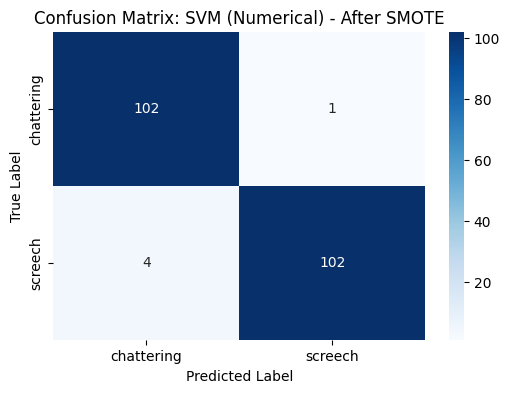

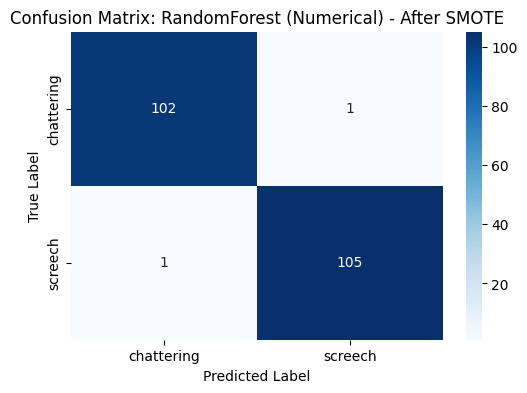

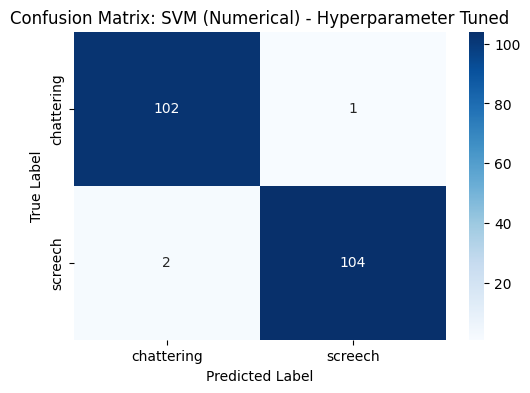

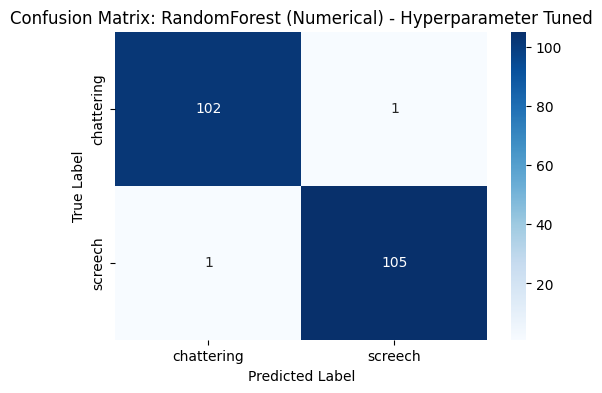

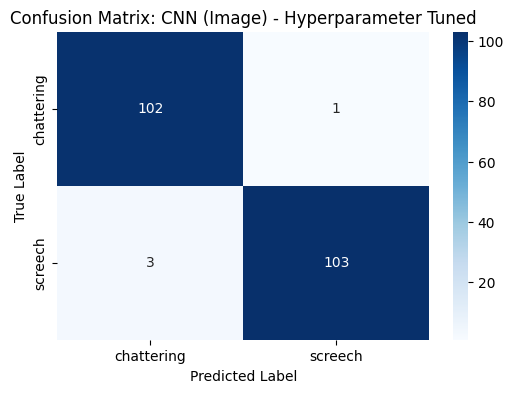


=== Model Evaluation Completed ===


In [11]:
print("\n=== Model Evaluation and Comparison Results ===")

# Collect performance metrics into a DataFrame for easier comparison
# Collecting data from the model_performance_results dictionary
evaluation_summary = []

for key, metrics in model_performance_results.items():
    model_name_parts = key.split('_')
    model_name = model_name_parts[0]
    feature_type = model_name_parts[1]
    stage_parts = model_name_parts[2:]
    # Reconstruct the stage name for better readability in English
    stage = " ".join(stage_parts).replace("FS", "Feature Selection").replace("Before Imbalance", "Before Imbalance Handling").replace("After SMOTE", "After SMOTE").replace("Initial", "Initial (No Tuning/Aug)").replace("Tuned", "Hyperparameter Tuned").replace("Augmentation", "After Augmentation")

    eval_dict = {
        'Model': model_name,
        'Feature Type': feature_type,
        'Stage': stage,
        'Accuracy': metrics.get('accuracy', np.nan),
        'Balanced Accuracy': metrics.get('balanced_accuracy', np.nan),
        'F1 Chattering': metrics.get('f1_chattering', np.nan),
        'Recall Chattering': metrics.get('recall_chattering', np.nan),
        'Precision Chattering': metrics.get('precision_chattering', np.nan),
        'F1 Screech': metrics.get('f1_screech', np.nan),
        'Recall Screech': metrics.get('recall_screech', np.nan),
        'Precision Screech': metrics.get('precision_screech', np.nan),
        'Confusion Matrix': metrics.get('confusion_matrix', 'N/A'),
        'Best Params': metrics.get('best_params', 'N/A')
    }
    # Add validation metrics for DL models if available
    if 'CNN' in model_name and 'history_cnn_initial' in globals() and 'history_cnn_augmented' in globals() and 'history_cnn_tuned_dl' in globals():
        if stage == 'Initial (No Tuning/Aug)' and 'history_cnn_initial' in globals():
             eval_dict['Val Accuracy'] = history_cnn_initial.history.get('val_accuracy', [np.nan])[-1]
             eval_dict['Val Loss'] = history_cnn_initial.history.get('val_loss', [np.nan])[-1]
        elif stage == 'After Augmentation' and 'history_cnn_augmented' in globals():
             eval_dict['Val Accuracy'] = history_cnn_augmented.history.get('val_accuracy', [np.nan])[-1]
             eval_dict['Val Loss'] = history_cnn_augmented.history.get('val_loss', [np.nan])[-1]
        elif stage == 'Hyperparameter Tuned' and 'history_cnn_tuned_dl' in globals():
            eval_dict['Val Accuracy'] = history_cnn_tuned_dl.history.get('val_accuracy', [np.nan])[-1]
            eval_dict['Val Loss'] = history_cnn_tuned_dl.history.get('val_loss', [np.nan])[-1]
    else:
        eval_dict['Val Accuracy'] = np.nan
        eval_dict['Val Loss'] = np.nan


    evaluation_summary.append(eval_dict)

# Create the main DataFrame with all results
summary_df = pd.DataFrame(evaluation_summary)

# Display the summary table with relevant metrics
print("\n--- Overall Performance Summary ---")
summary_df_display = summary_df.set_index(['Model', 'Feature Type', 'Stage']).drop(columns=['Confusion Matrix', 'Best Params'])
display(summary_df_display.round(3))


print("\n--- Performance Comparison by Stage ---")

# Pre/Post Feature Selection (Comparison for Numerical Features)
print("\n>> Feature Selection Stages Comparison (Numerical Features):")
fs_stages = ['Initial (No Tuning/Aug)', 'Numerical_RF_Feature Selection', 'Numerical_RFE_Feature Selection', 'Numerical_PCA_Feature Selection']
# Filter summary_df based on the corrected stage names and feature type
display(summary_df[
    (summary_df['Feature Type'] == 'Numerical') &
    (summary_df['Stage'].isin(fs_stages))
].set_index(['Model', 'Feature Type', 'Stage']).drop(columns=['Confusion Matrix', 'Best Params', 'Val Accuracy', 'Val Loss']).sort_values(by=['Model', 'Stage']).round(3))


# Pre/Post Imbalance Handling & Augmentation (Comparison)
print("\n>> Imbalance Handling / Augmentation Stages Comparison:")
# Correct the stage names to match the DataFrame
imbal_stages_num = ['Initial (No Tuning/Aug)', 'After SMOTE'] # Corrected stage names
imbal_stages_img = ['Initial (No Tuning/Aug)', 'After Augmentation'] # Corrected stage names

display(summary_df[
    ((summary_df['Feature Type'] == 'Numerical') & (summary_df['Stage'].isin(imbal_stages_num))) |
    ((summary_df['Feature Type'] == 'Image') & (summary_df['Stage'].isin(imbal_stages_img)))
].set_index(['Model', 'Feature Type', 'Stage']).drop(columns=['Confusion Matrix', 'Best Params']).sort_values(by=['Model', 'Feature Type', 'Stage']).round(3))


# Traditional vs Deep Learning Models (Comparison of Final Tuned/Processed Models)
print("\n>> Traditional ML vs Deep Learning Models Comparison (Final Processed/Tuned):")
# Correct the stage name to match the DataFrame
final_stages = ['Hyperparameter Tuned']
display(summary_df[
    (summary_df['Stage'].isin(final_stages))
].set_index(['Model', 'Feature Type', 'Stage']).drop(columns=['Confusion Matrix', 'Best Params']).sort_values(by=['Model', 'Feature Type']).round(3))


# Pre/Post Tuning (Comparison)
print("\n>> Tuning Stages Comparison (Initial vs Tuned):")
# Correct the stage names to match the DataFrame
tuning_stages = ['Initial (No Tuning/Aug)', 'Hyperparameter Tuned']
display(summary_df[
    (summary_df['Stage'].isin(tuning_stages))
].set_index(['Model', 'Feature Type', 'Stage']).drop(columns=['Confusion Matrix', 'Best Params']).sort_values(by=['Model', 'Feature Type']).round(3))

# Check for Overfitting (Comparing Training/Validation Performance for DL Model)
print("\n--- Overfitting Check for CNN Model ---")
cnn_performance = summary_df[summary_df['Model'] == 'CNN'].set_index(['Model', 'Feature Type', 'Stage'])
display(cnn_performance[['Accuracy', 'Val Accuracy', 'Val Loss']].round(4))
print("Note: Compare 'Accuracy' (Training/Validation split within fit) with 'Val Accuracy' to check for overfitting.")


# Visualize Confusion Matrices (as Heatmaps)
print("\n--- Confusion Matrices (Heatmaps) ---")
for idx, row in summary_df.iterrows():
    stage = row['Stage']
    # Visualize heatmaps for relevant stages
    if stage in ['Initial (No Tuning/Aug)', 'Hyperparameter Tuned', 'After SMOTE', 'After Augmentation']:
        cm = row['Confusion Matrix']
        if isinstance(cm, np.ndarray):
            plt.figure(figsize=(6, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=le.classes_, yticklabels=le.classes_)
            plt.title(f"Confusion Matrix: {row['Model']} ({row['Feature Type']}) - {stage}")
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.show()
        else:
            print(f"\n{row['Model']} ({row['Feature Type']}) - {stage} Confusion Matrix: {cm}") # Print N/A message if matrix is not available


print("\n=== Model Evaluation Completed ===")


=== CNN Model Training History ===


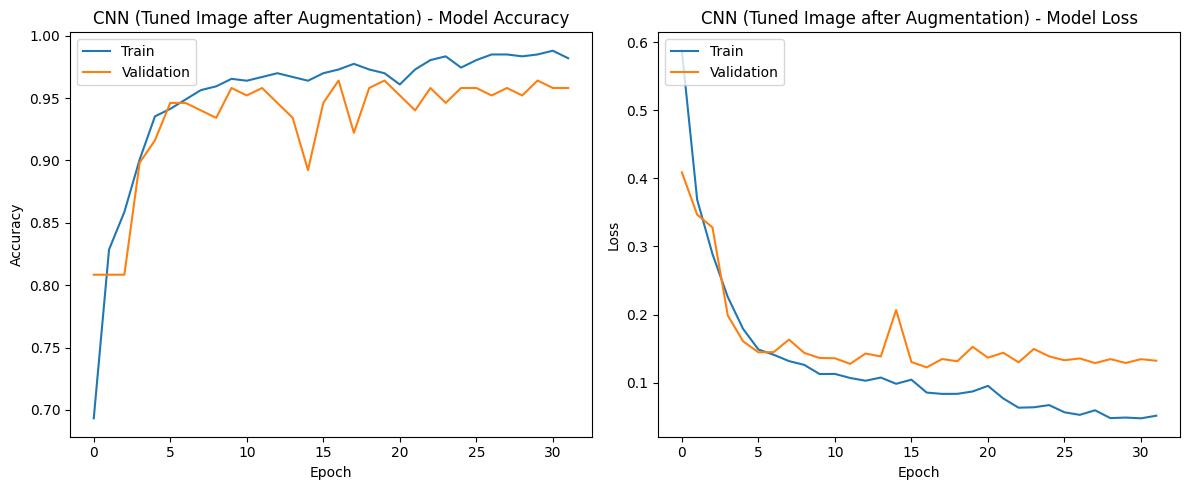


Final Training Accuracy: 0.9820
Final Validation Accuracy: 0.9581
Final Training Loss: 0.0516
Final Validation Loss: 0.1322


In [12]:
# Plotting training and validation metrics for the CNN model
import matplotlib.pyplot as plt

print("\n=== CNN Model Training History ===")

# Assuming history_cnn_initial, history_cnn_augmented, history_cnn_tuned_dl are available from previous steps
# You can choose which history to plot based on which CNN model you want to analyze
# For example, plotting the history of the tuned CNN model after augmentation:
if 'history_cnn_tuned_dl' in globals():
    history = history_cnn_tuned_dl
    model_stage = "CNN (Tuned Image after Augmentation)"
elif 'history_cnn_augmented' in globals():
     history = history_cnn_augmented
     model_stage = "CNN (Image after Augmentation)"
elif 'history_cnn_initial' in globals():
    history = history_cnn_initial
    model_stage = "CNN (Initial Image)"
else:
    history = None
    print("No CNN training history found to plot.")

if history:
    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_stage} - Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_stage} - Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

    # Print final training and validation metrics
    print(f"\nFinal Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")